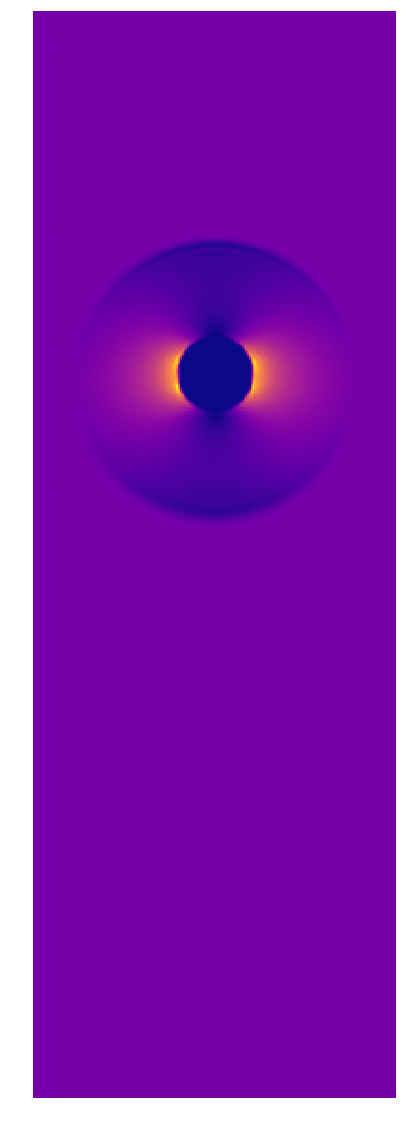

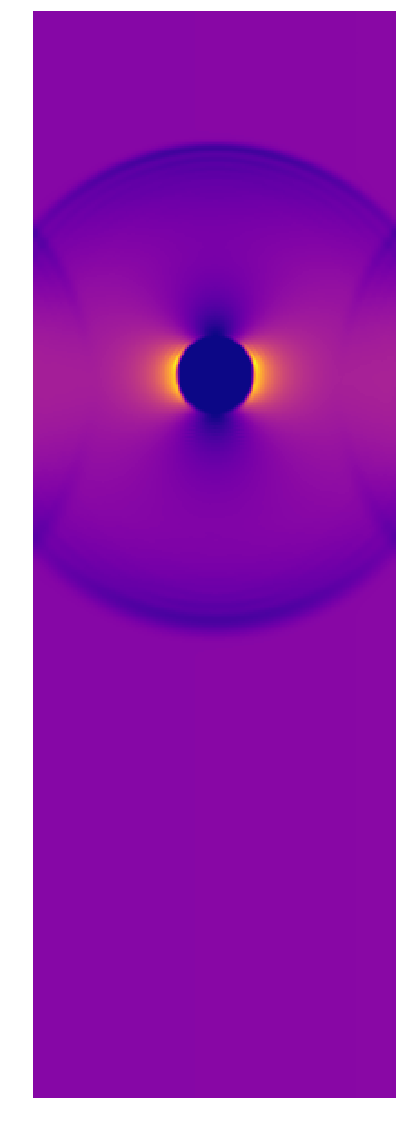

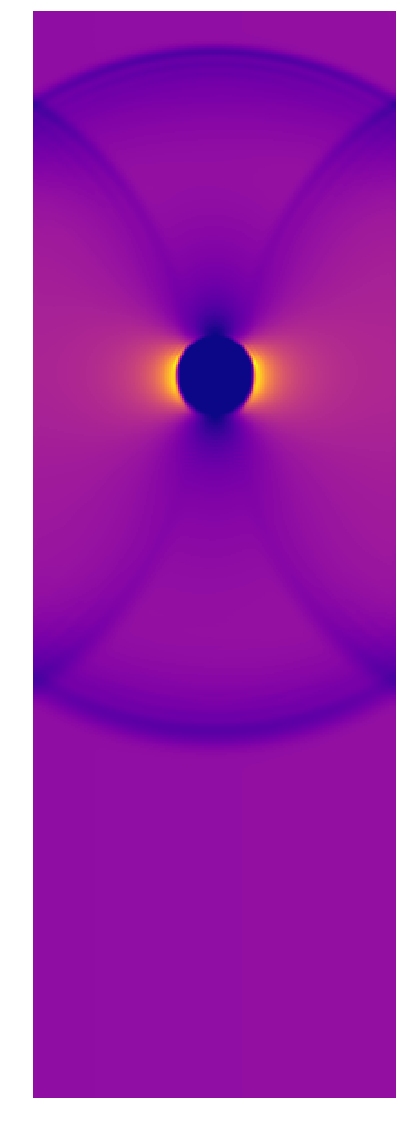

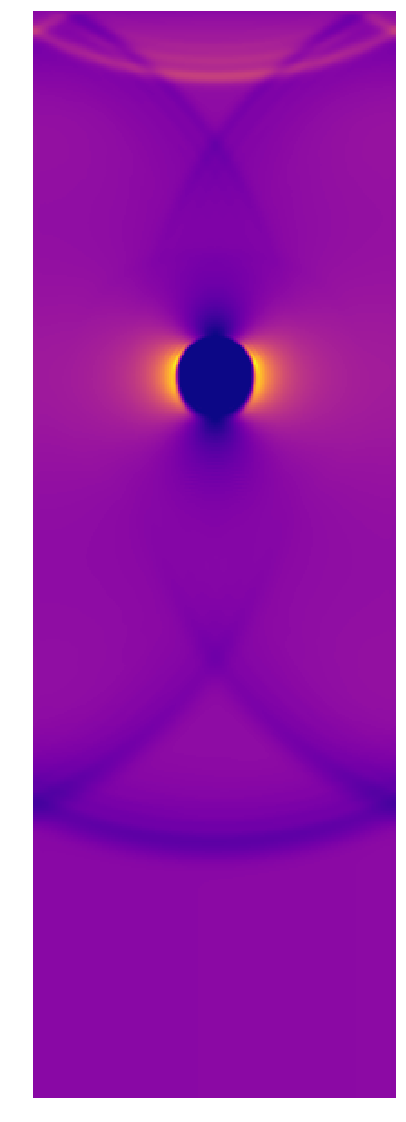

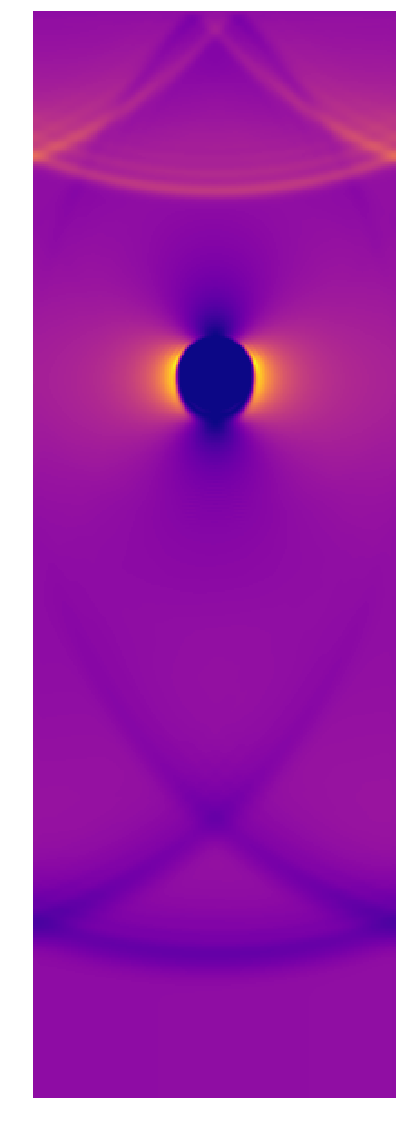

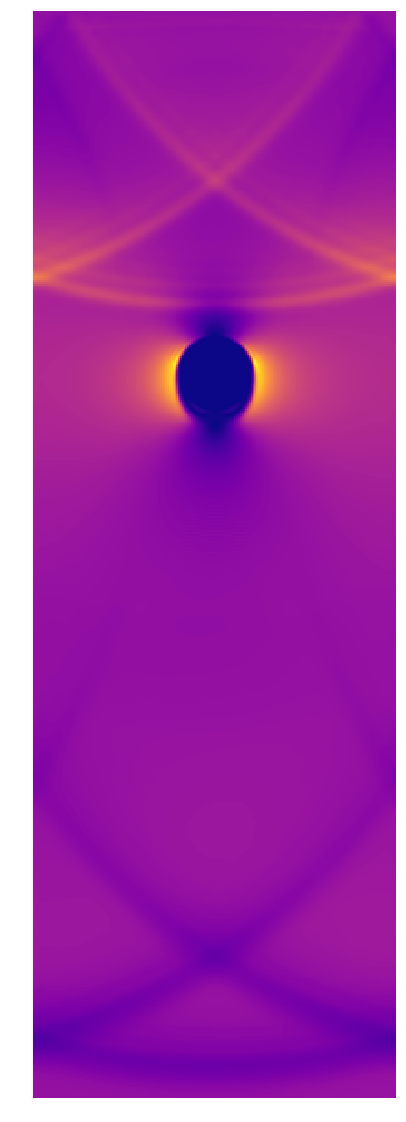

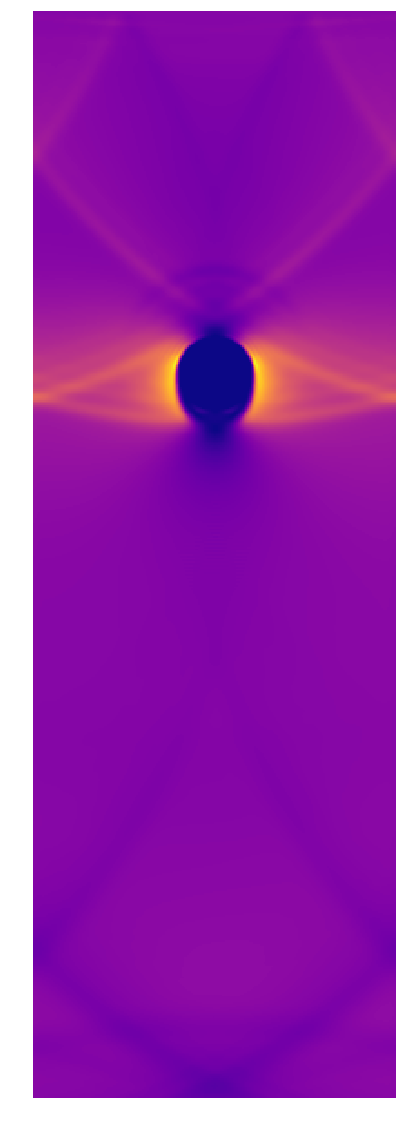

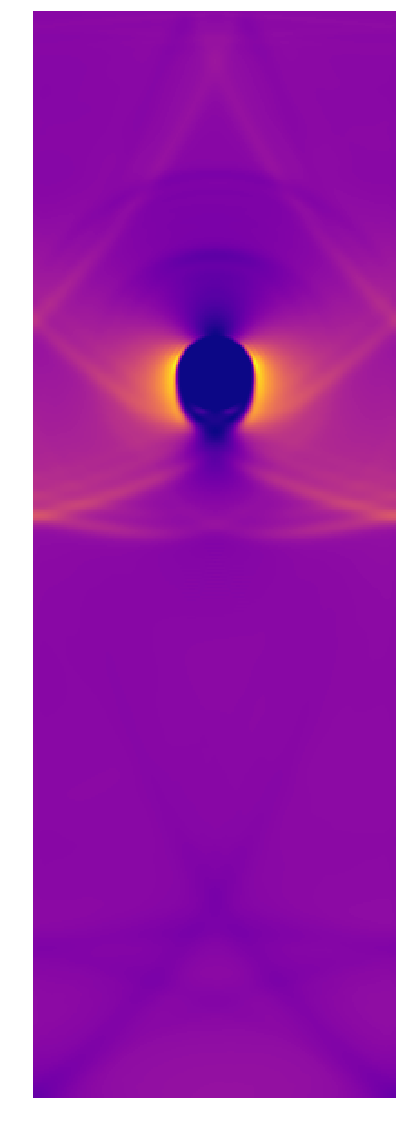

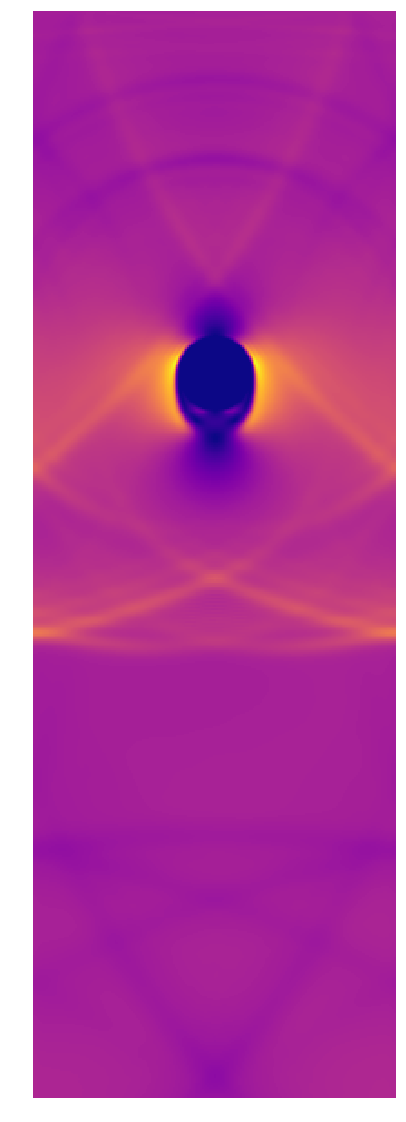

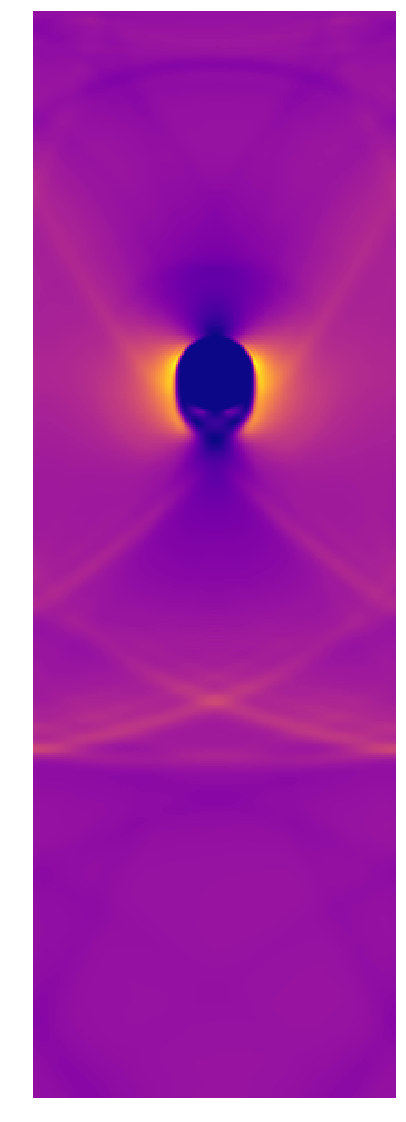

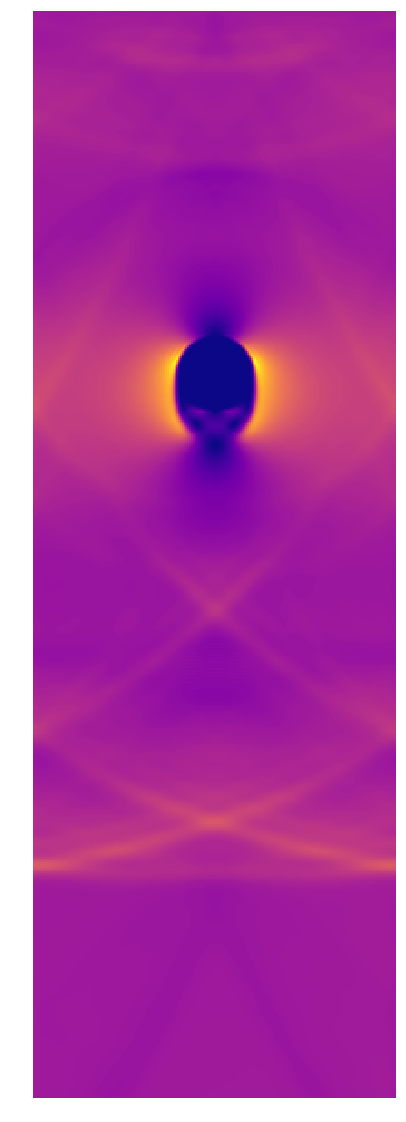

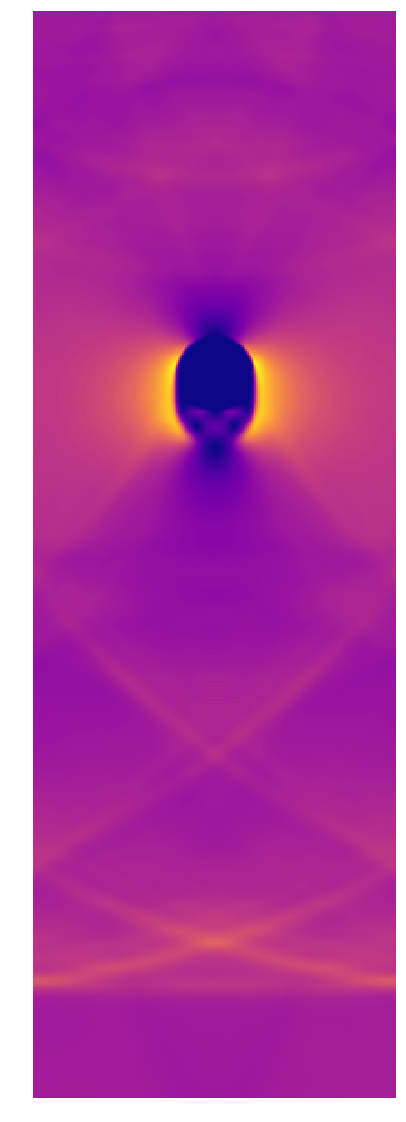

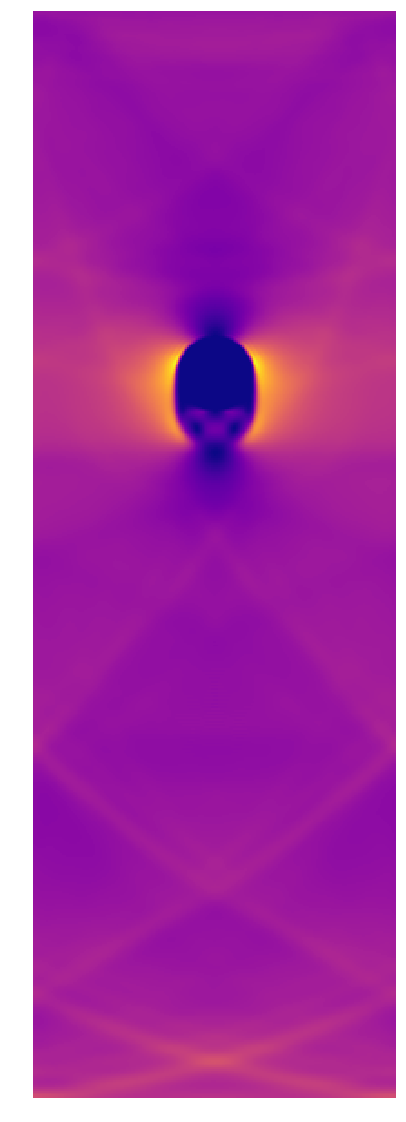

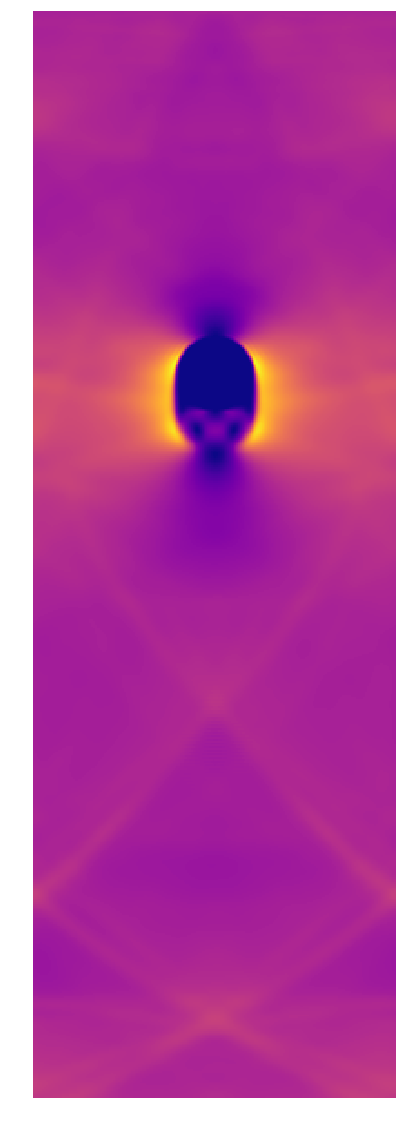

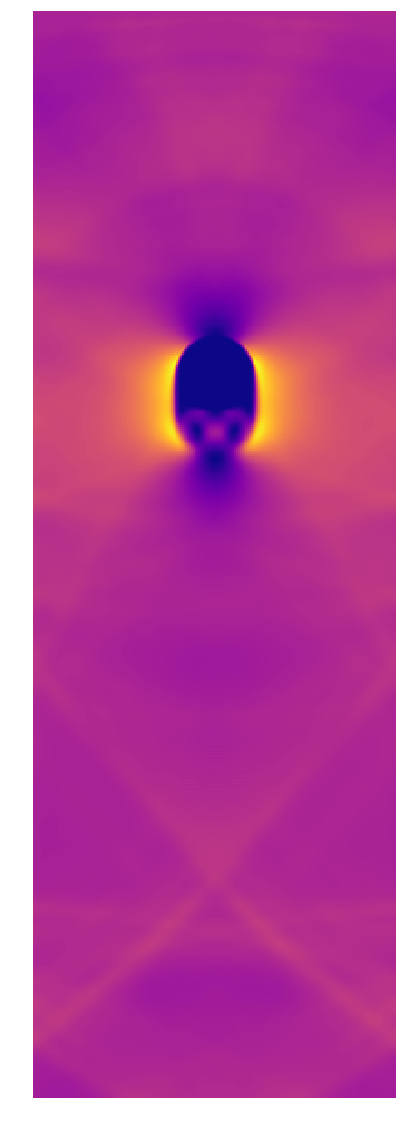

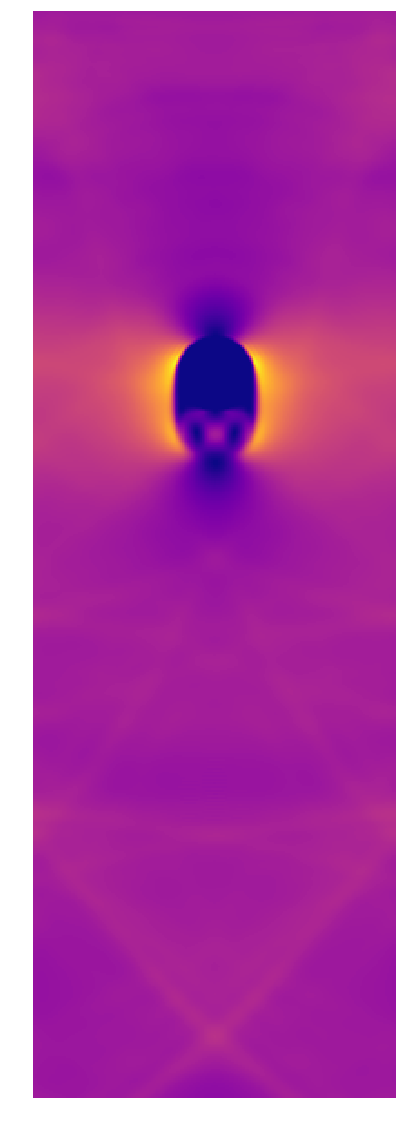

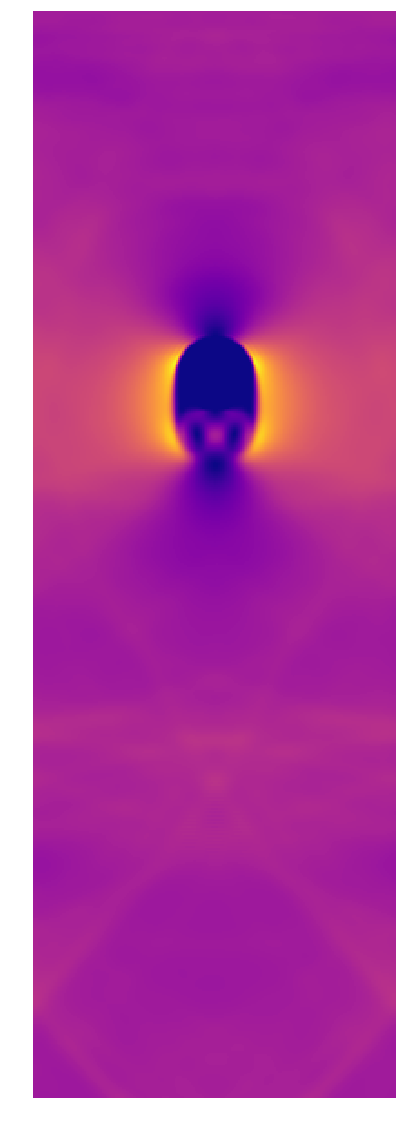

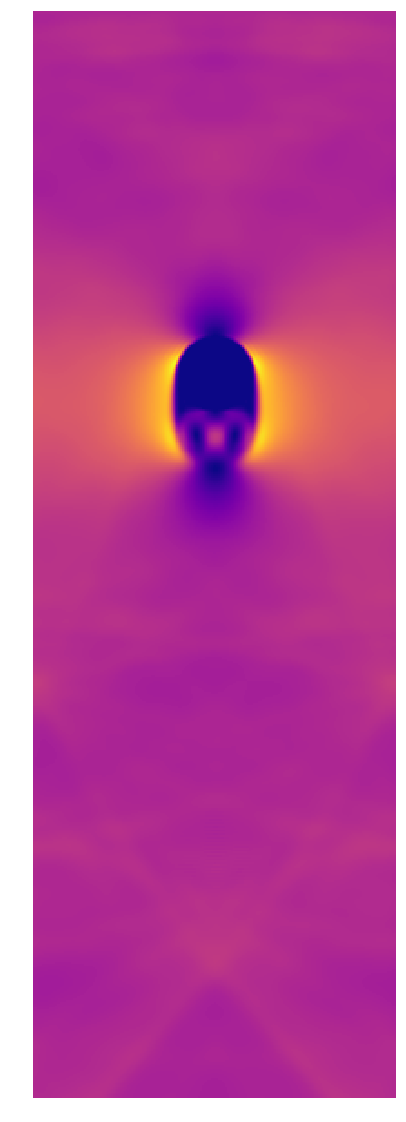

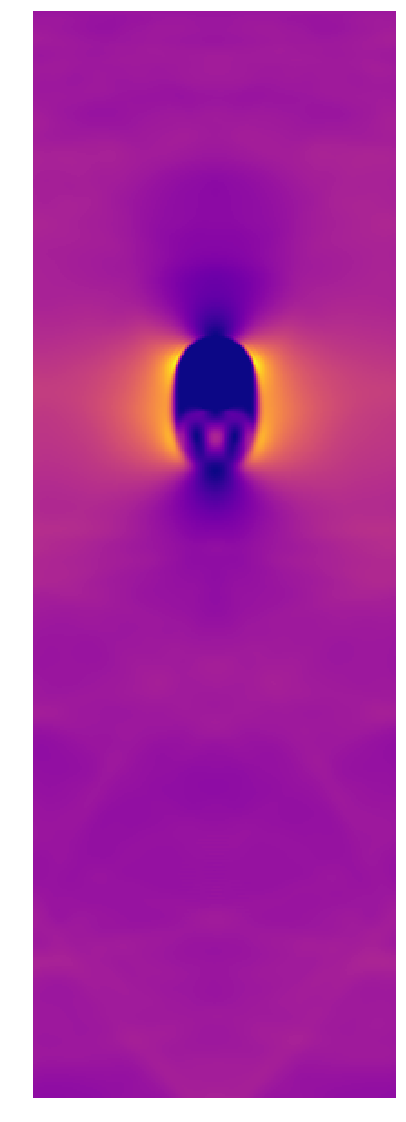

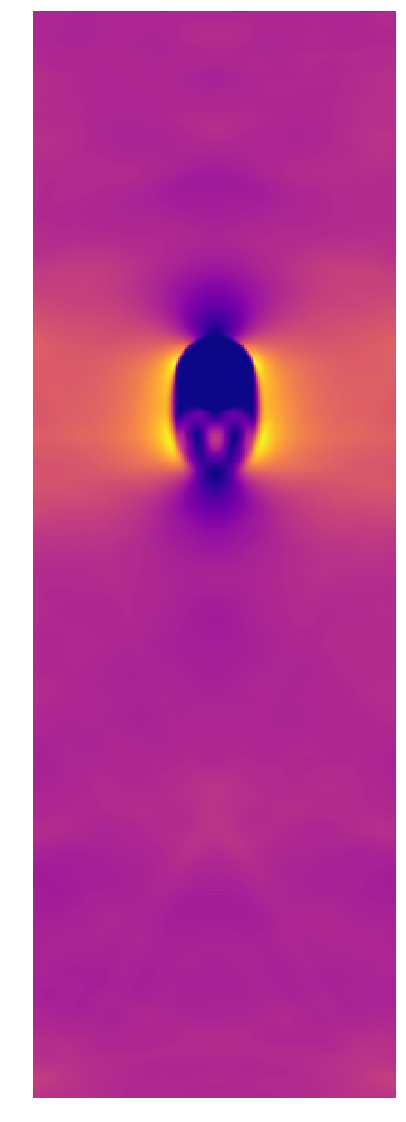

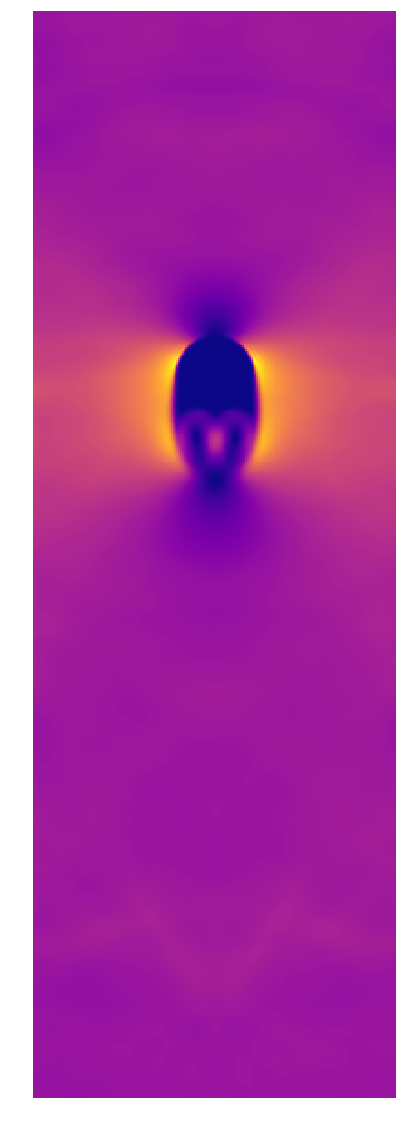

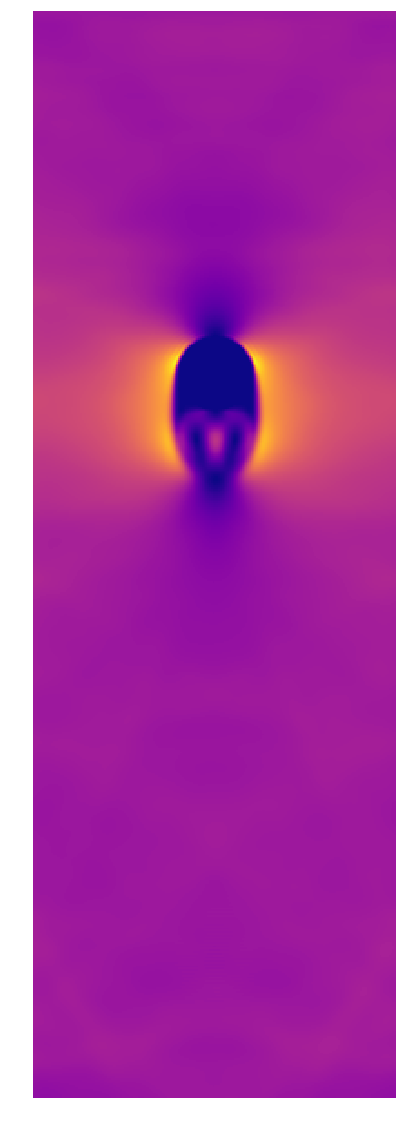

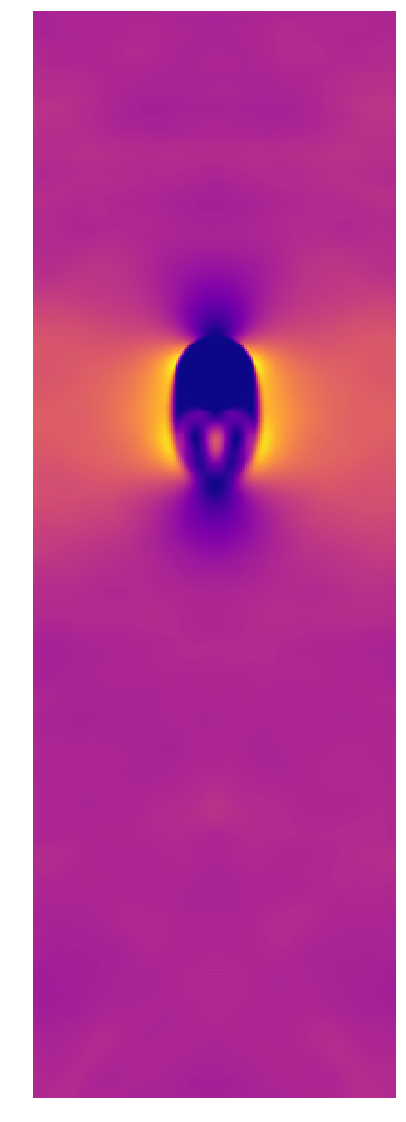

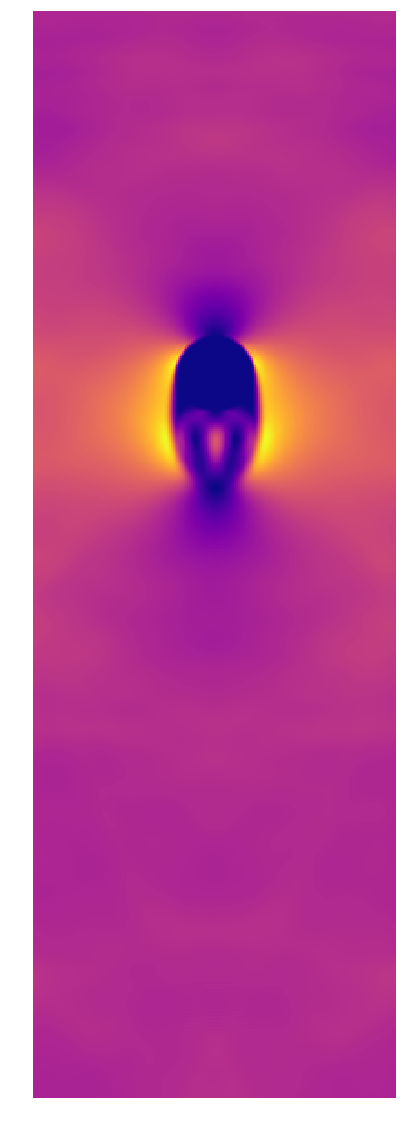

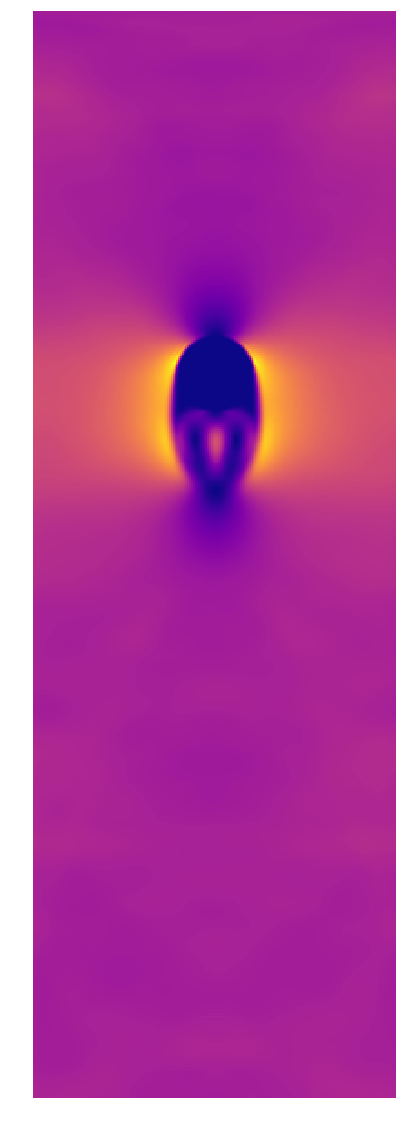

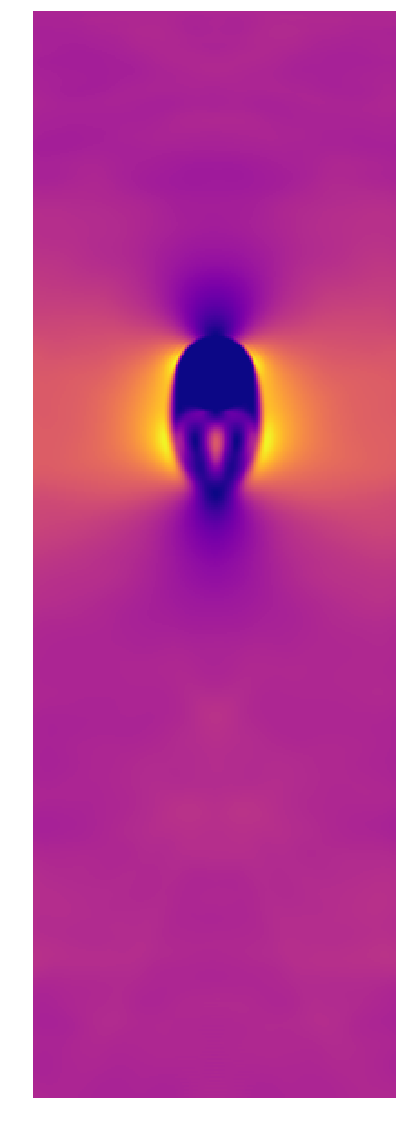

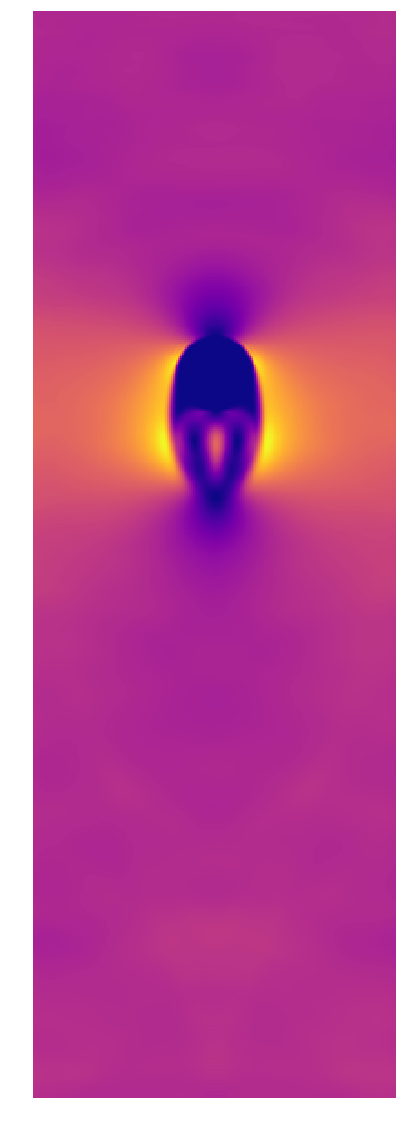

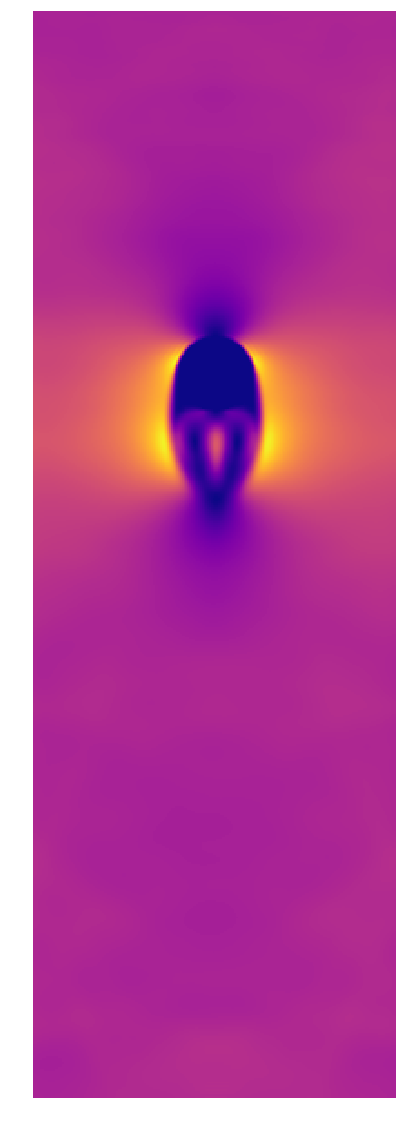

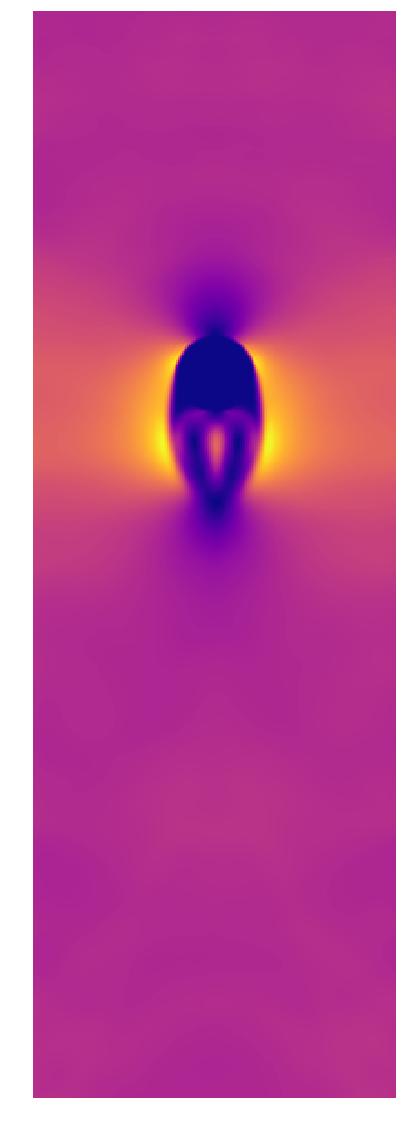

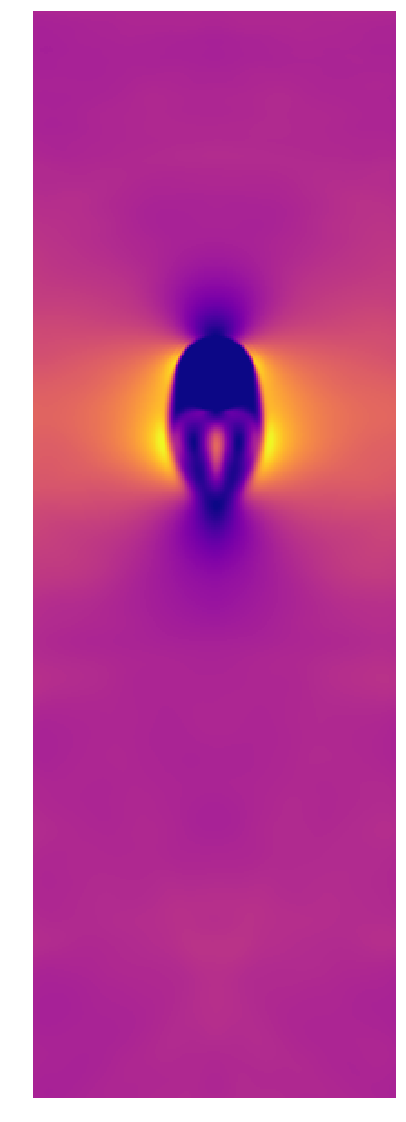

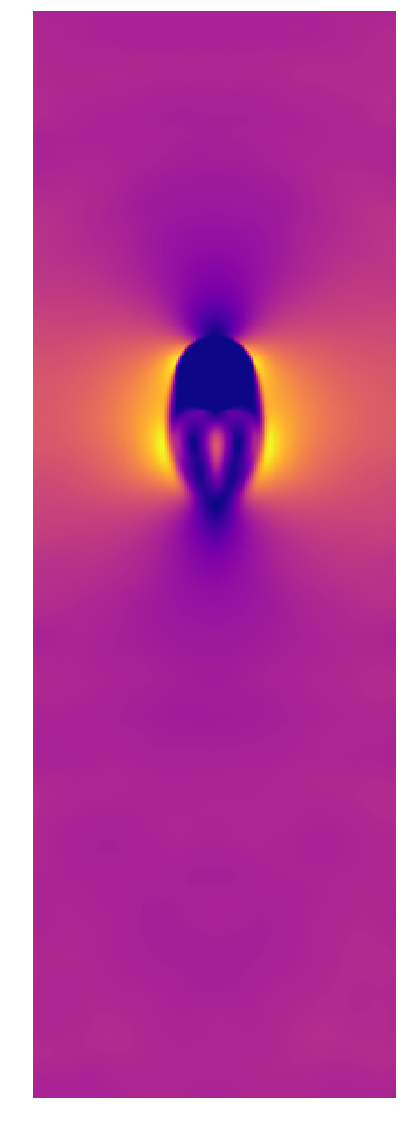

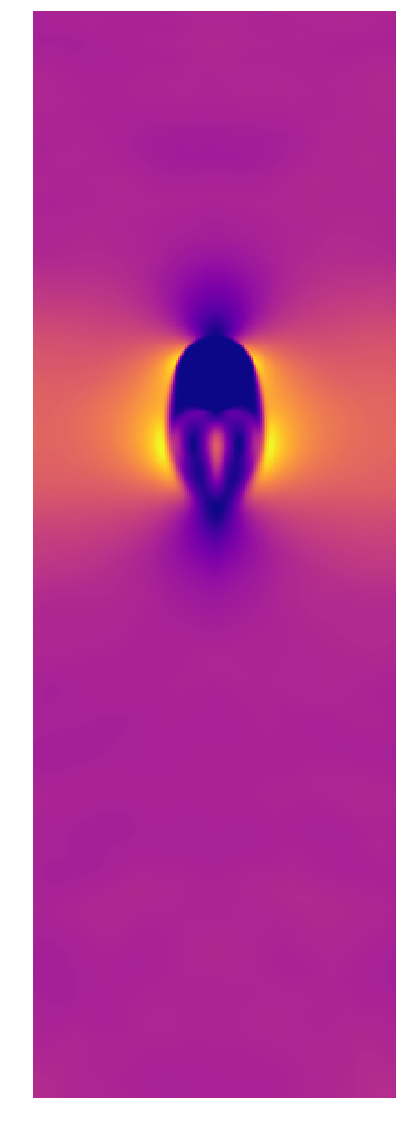

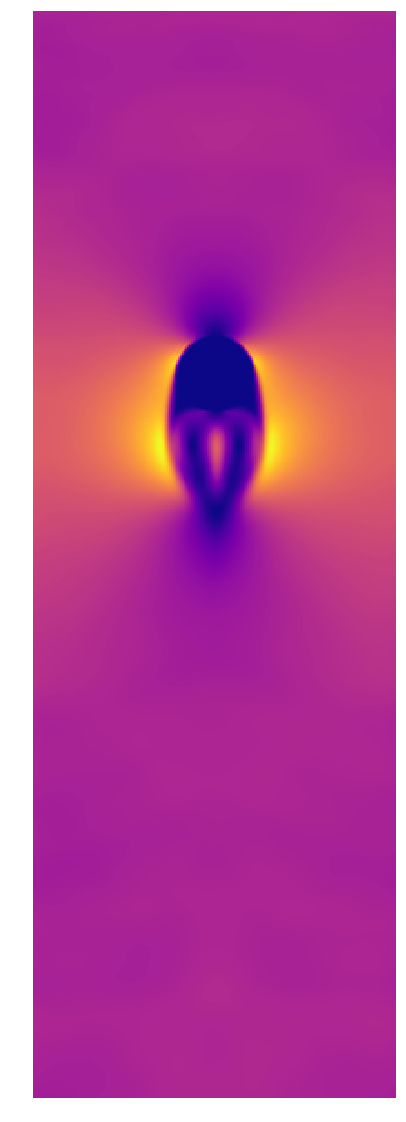

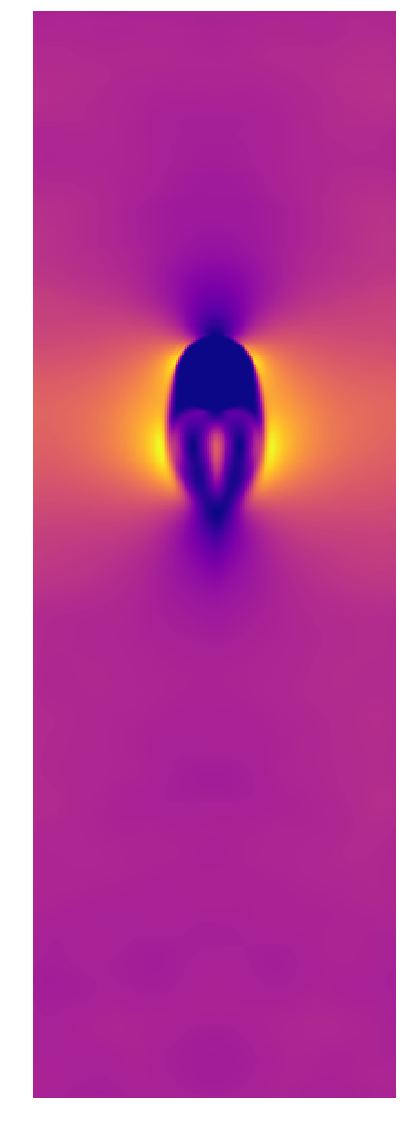

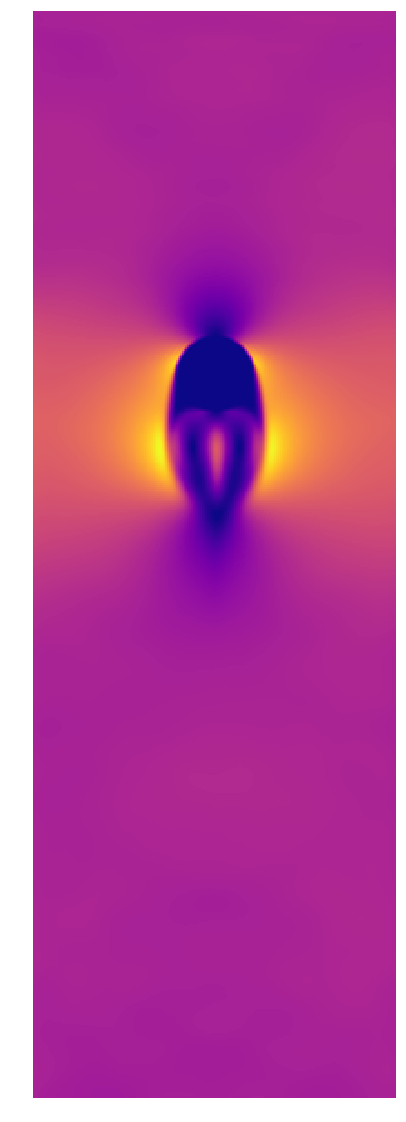

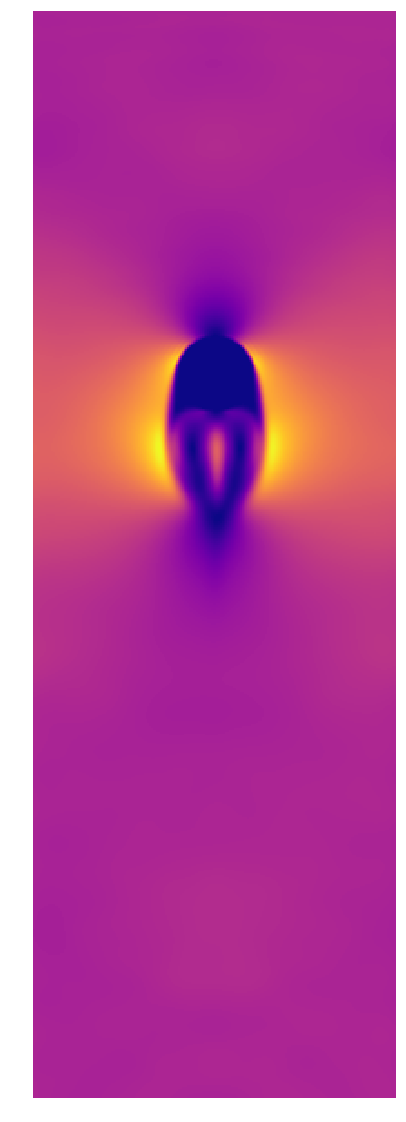

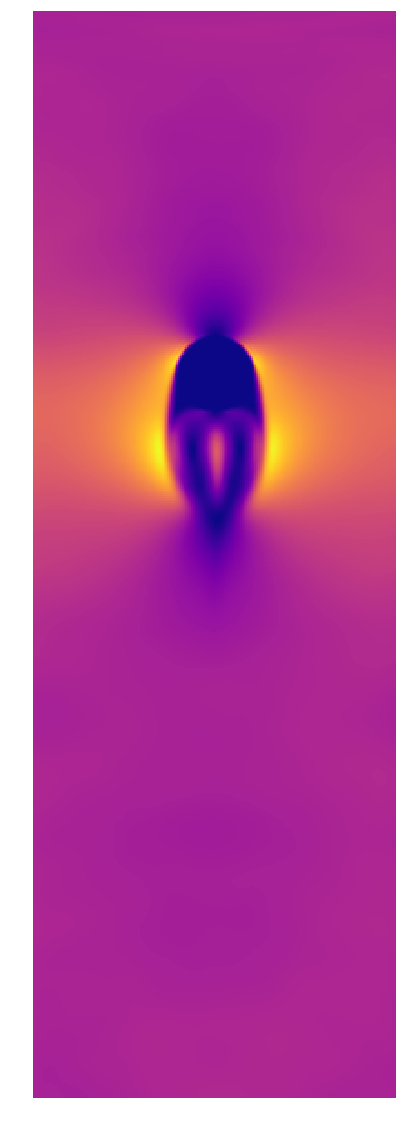

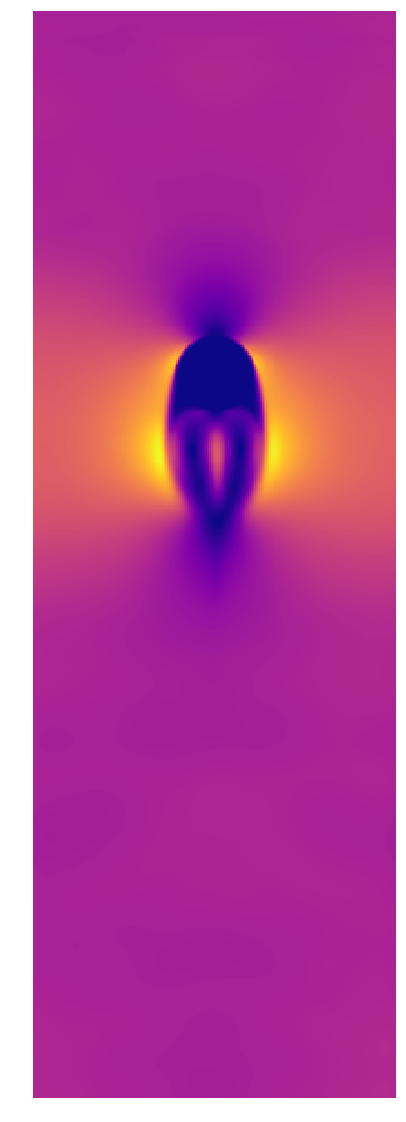

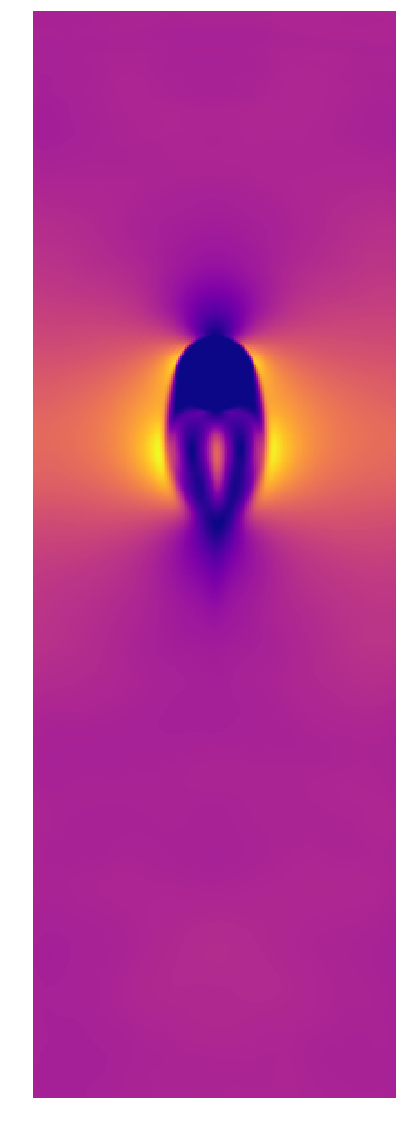

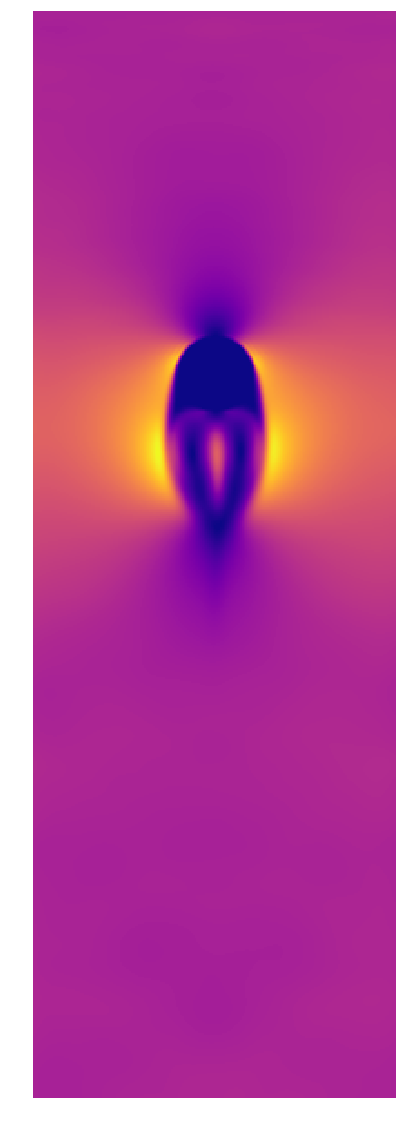

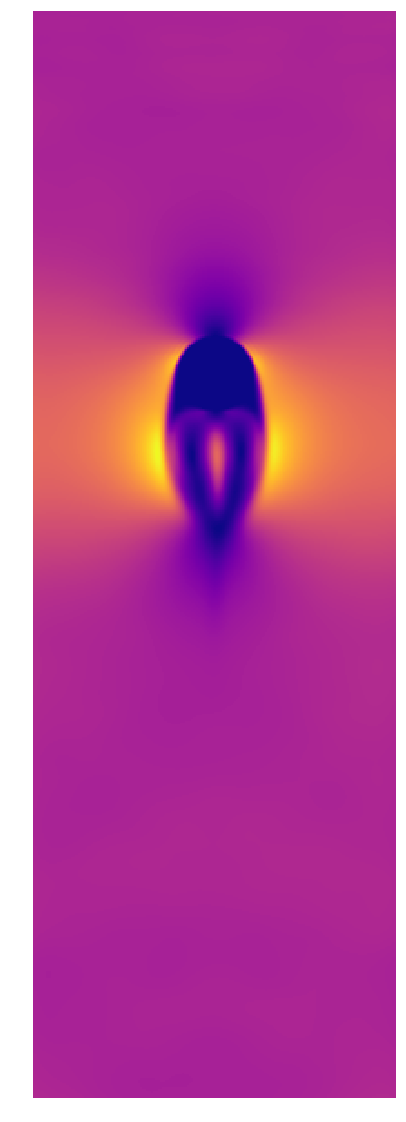

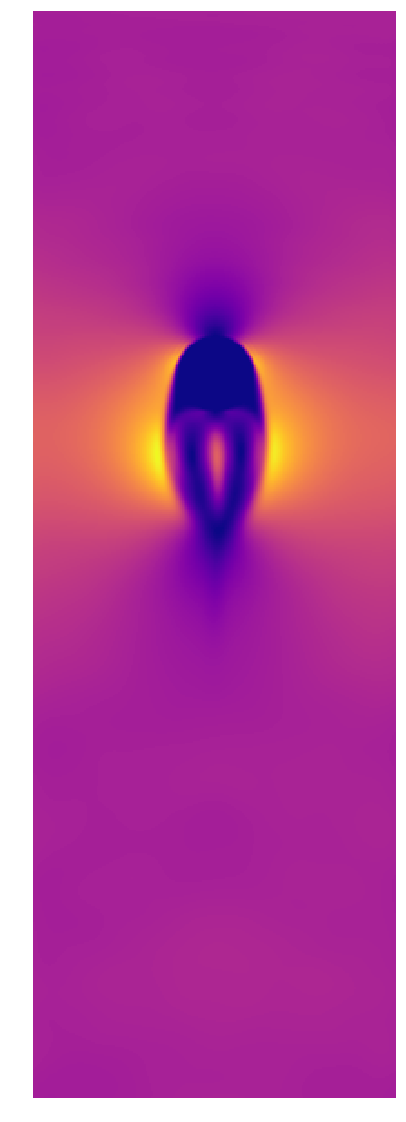

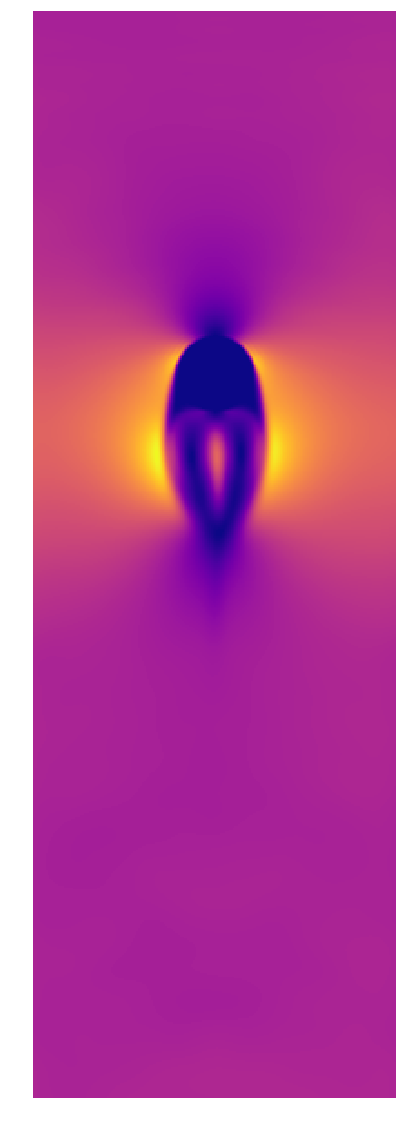

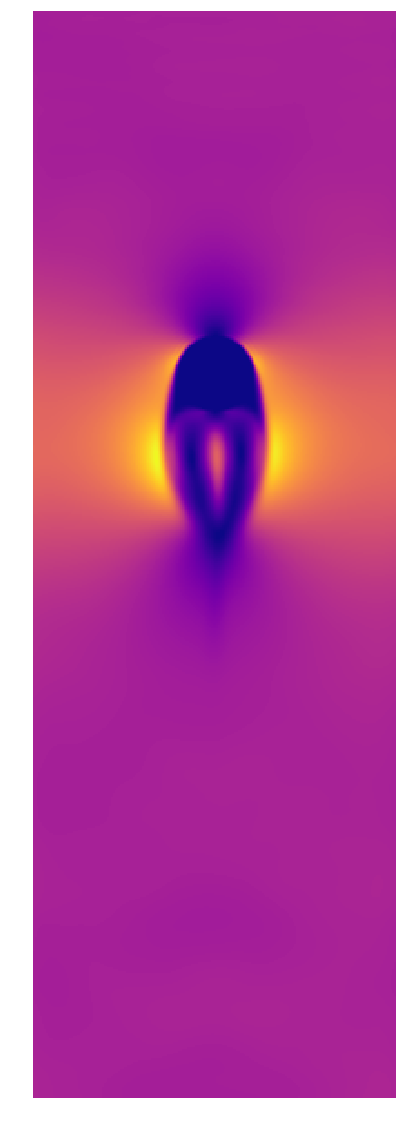

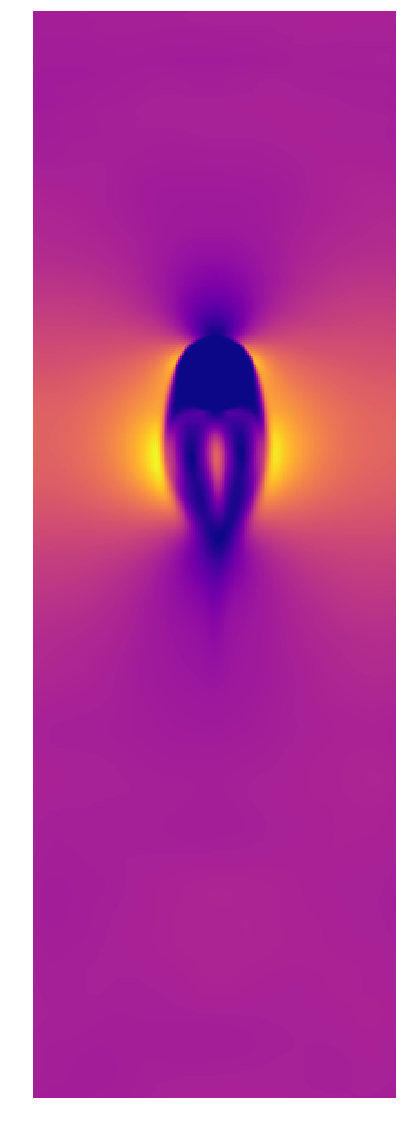

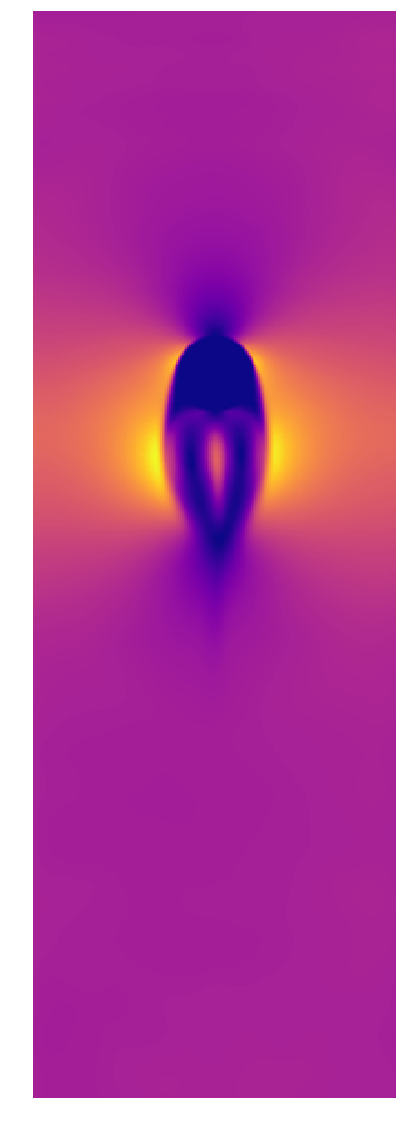

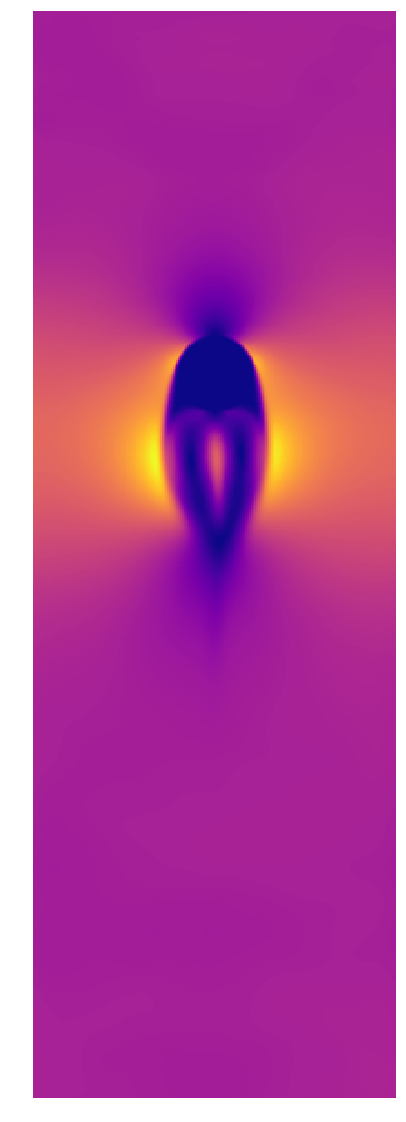

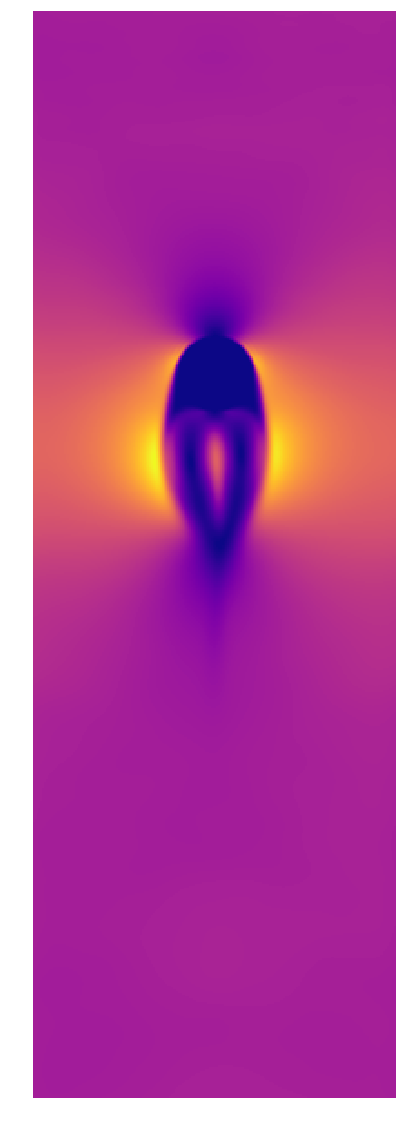

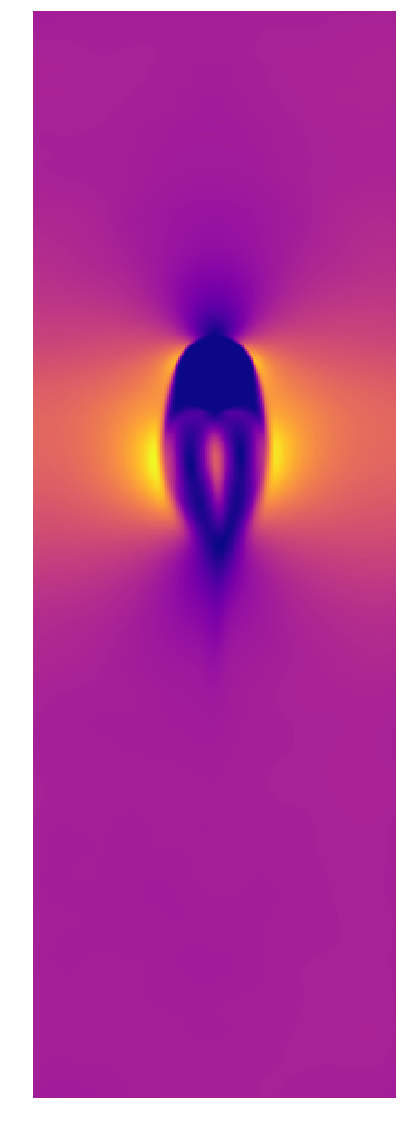

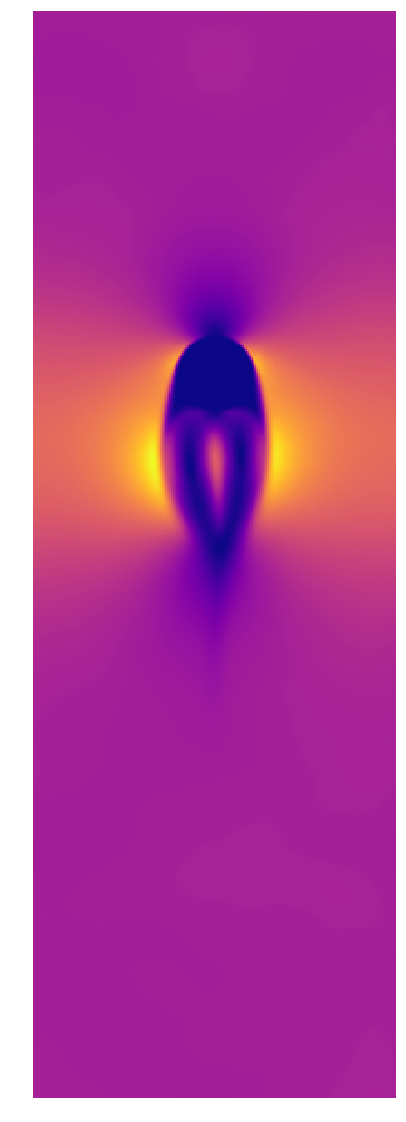

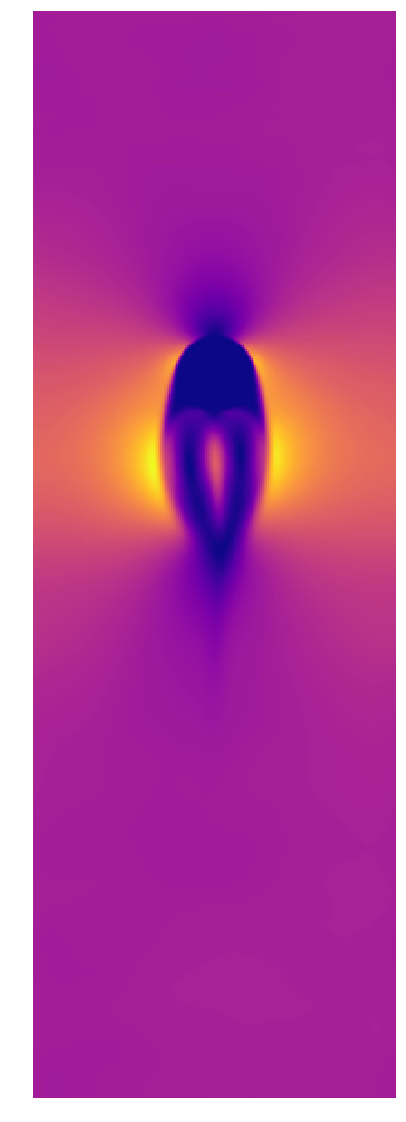

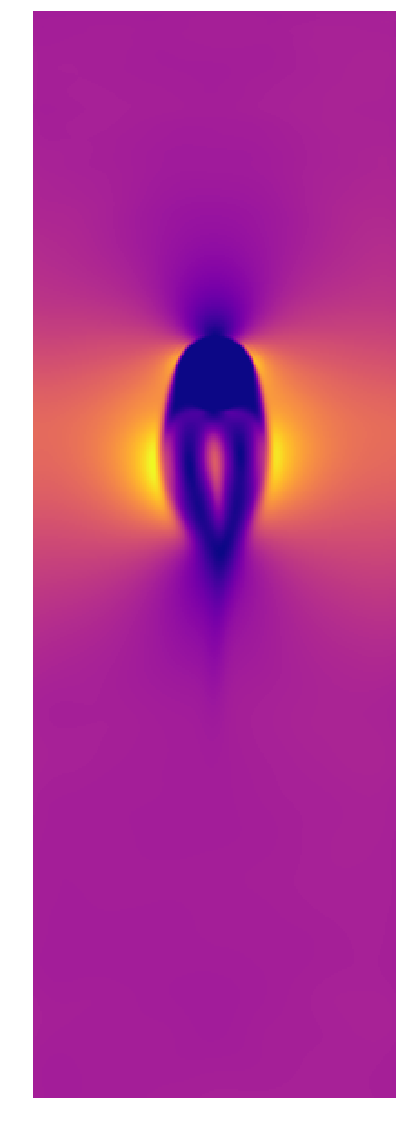

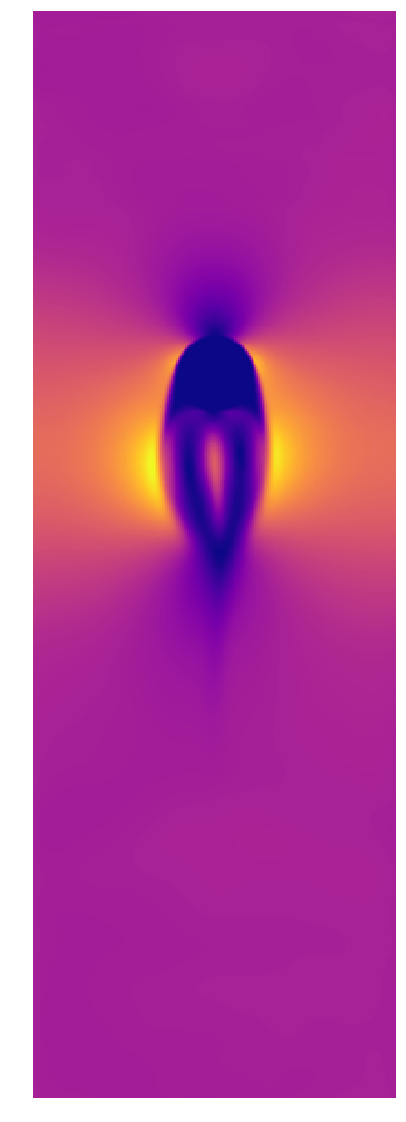

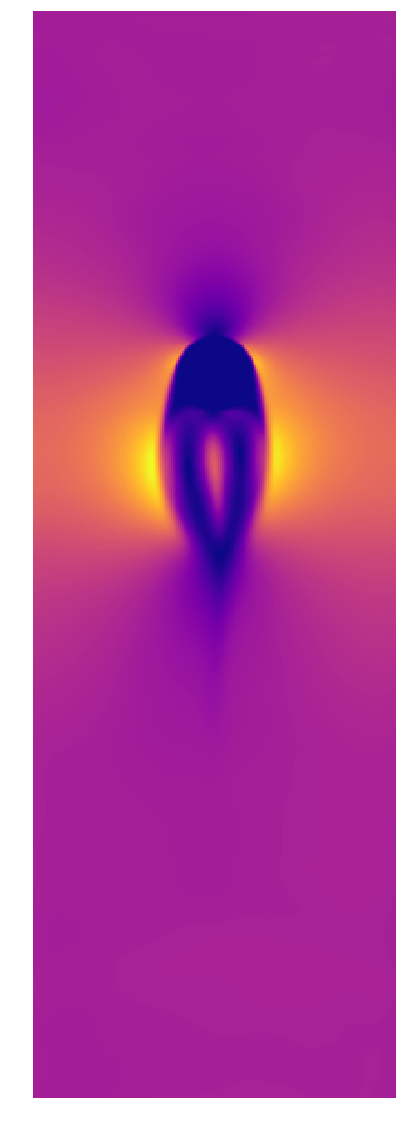

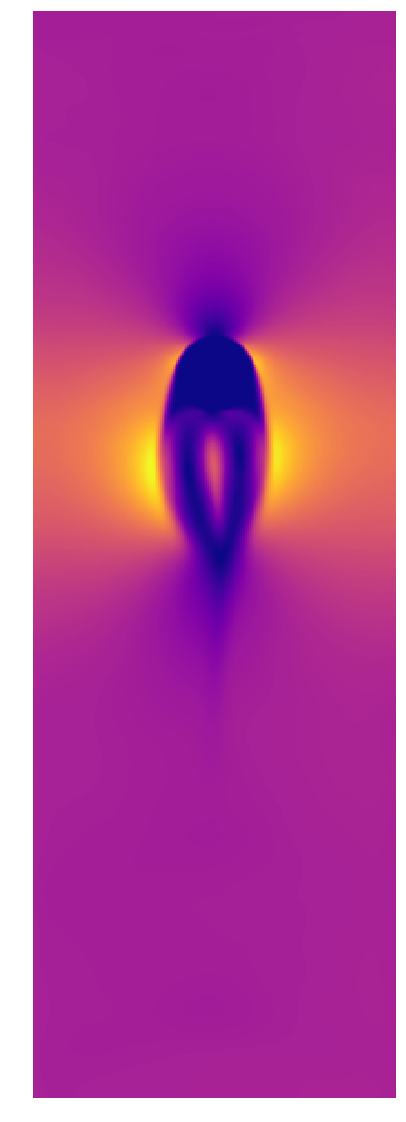

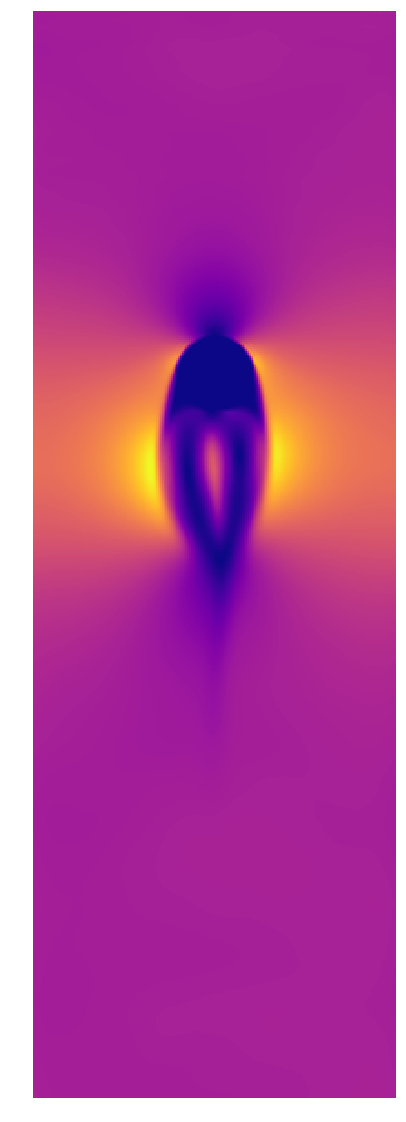

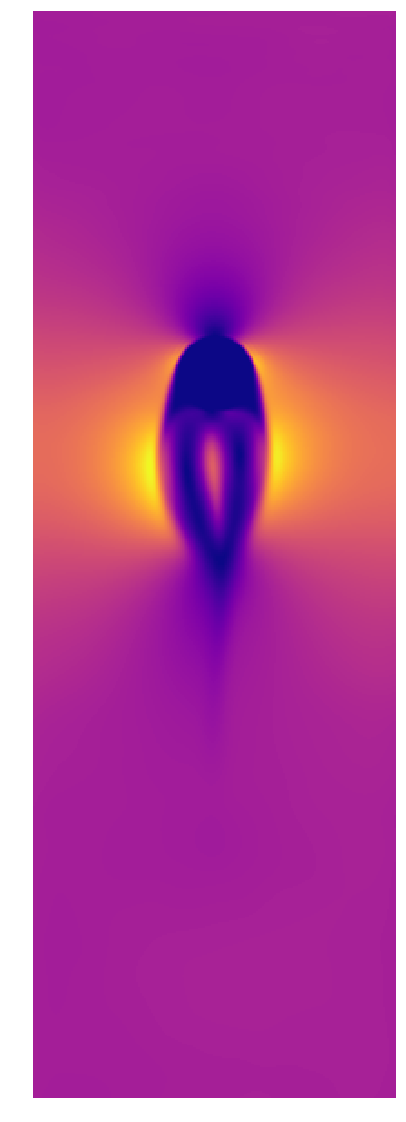

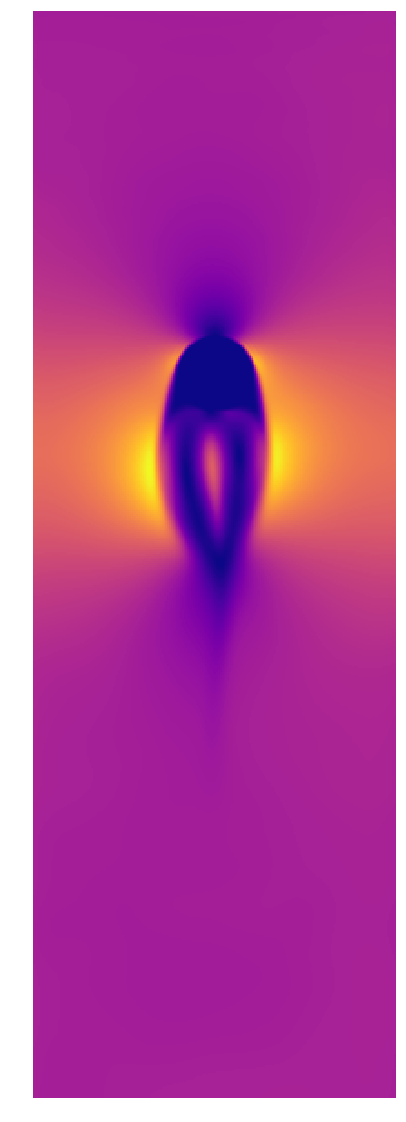

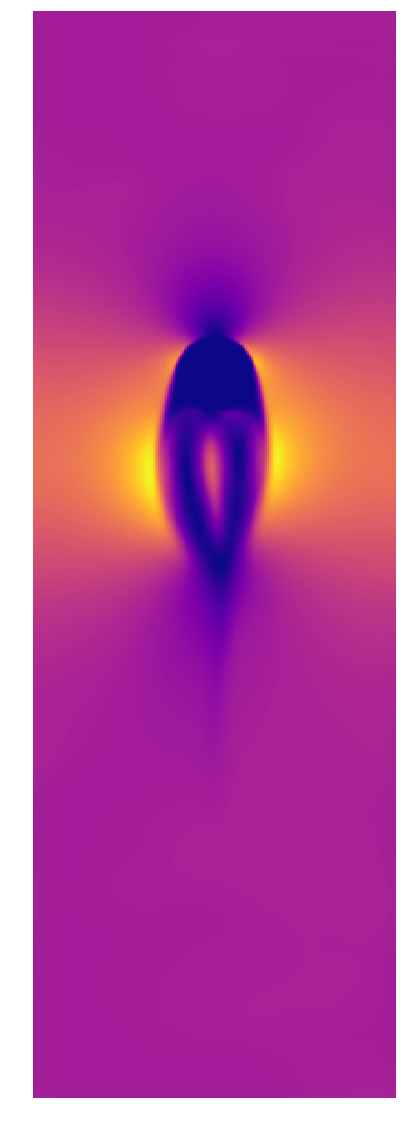

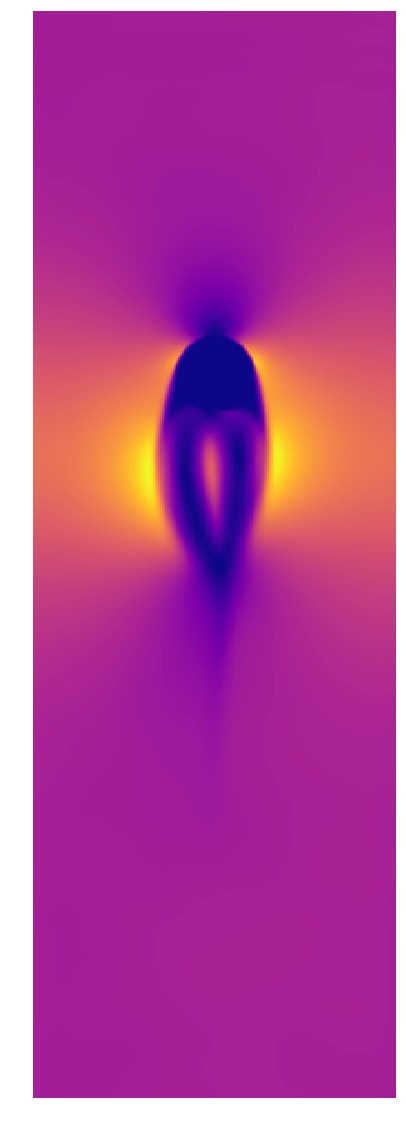

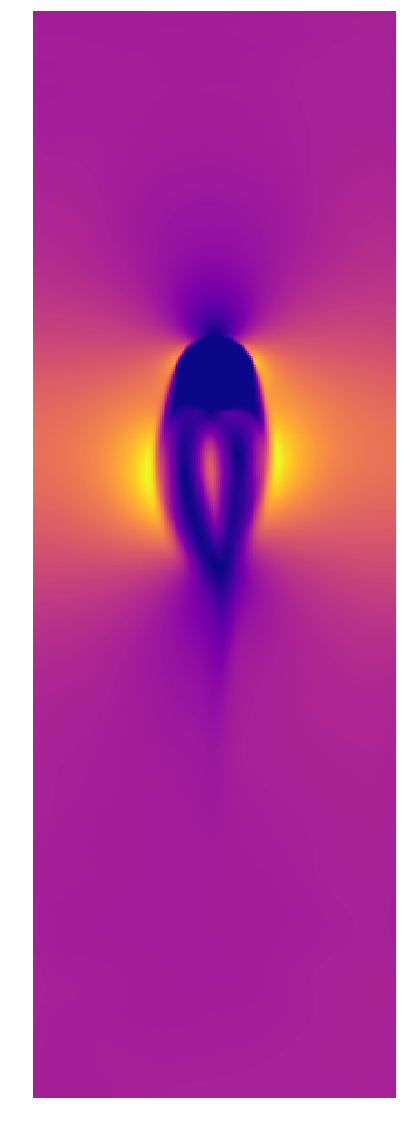

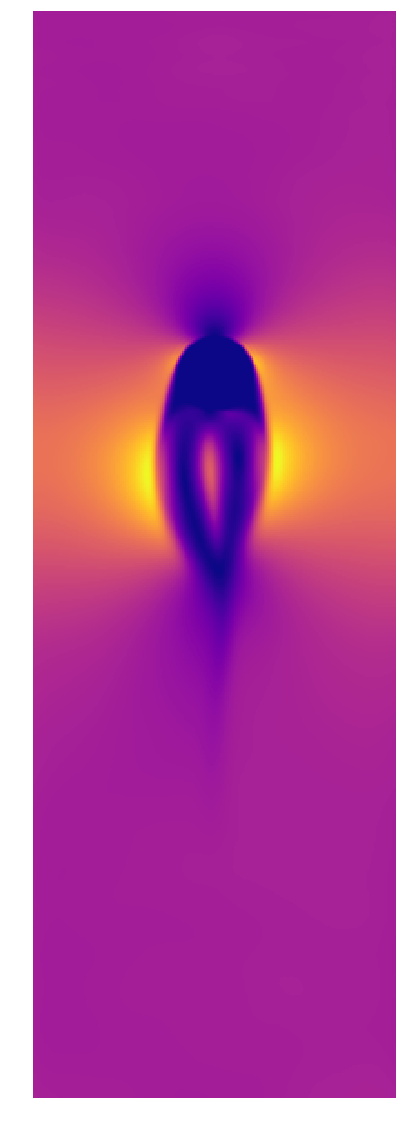

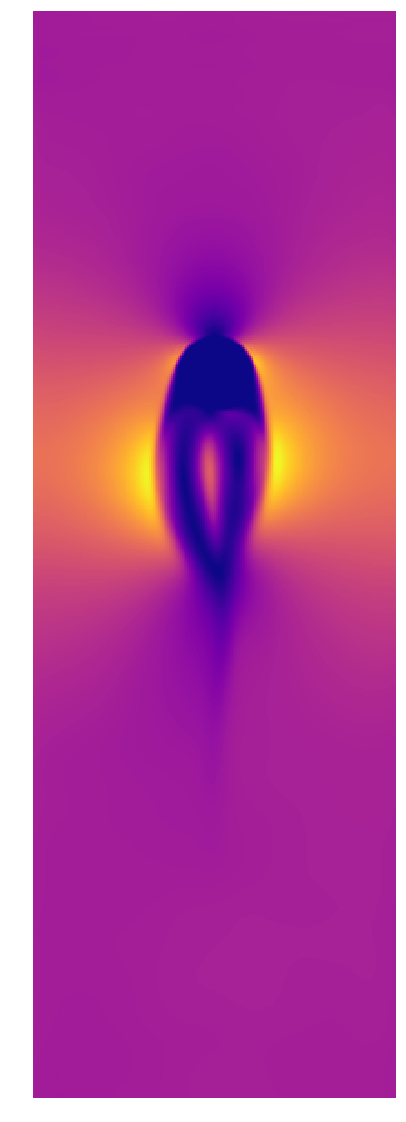

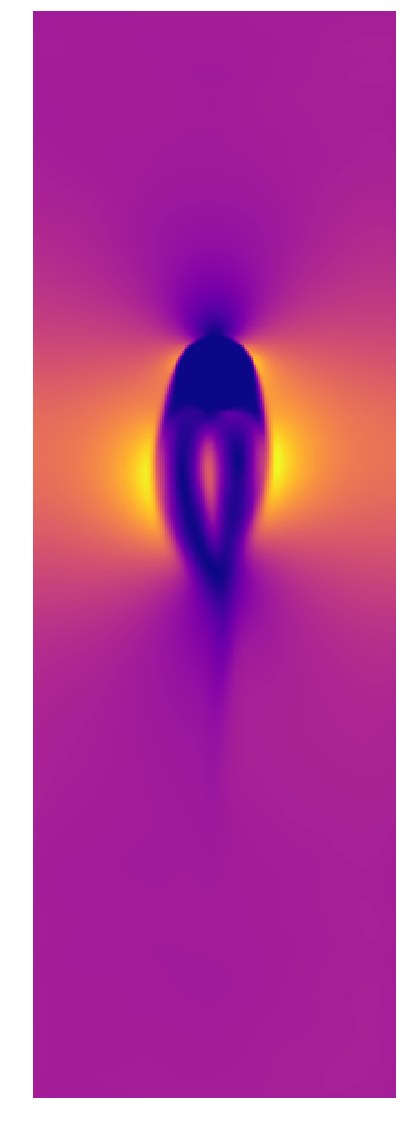

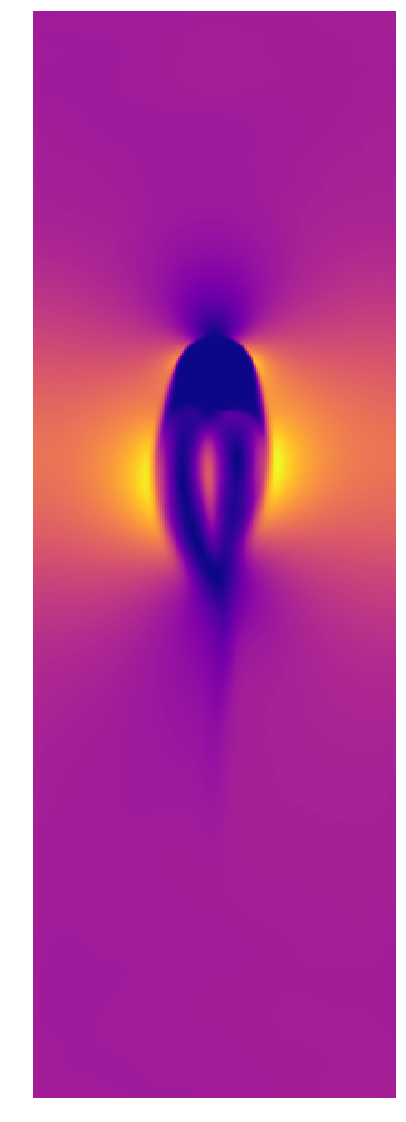

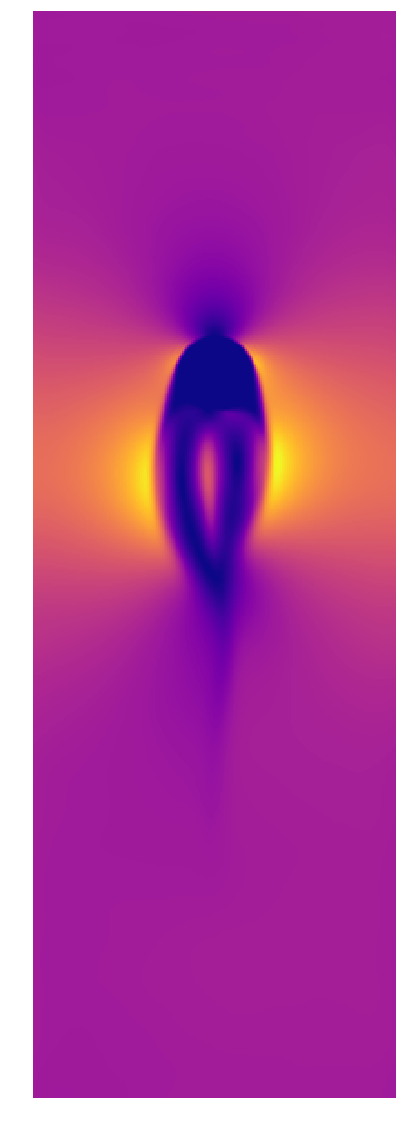

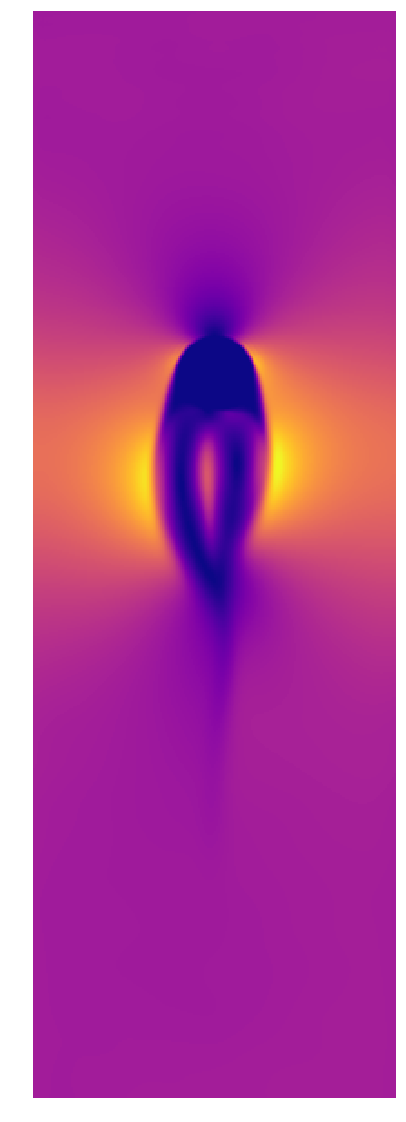

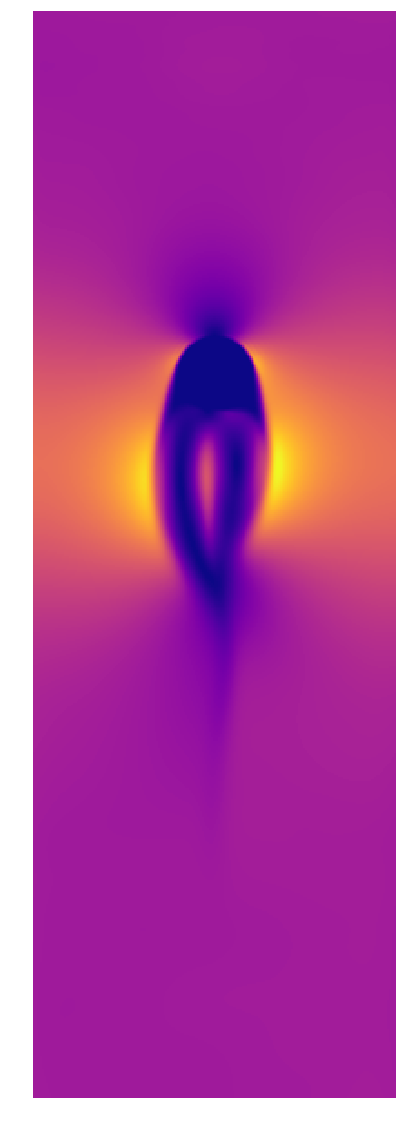

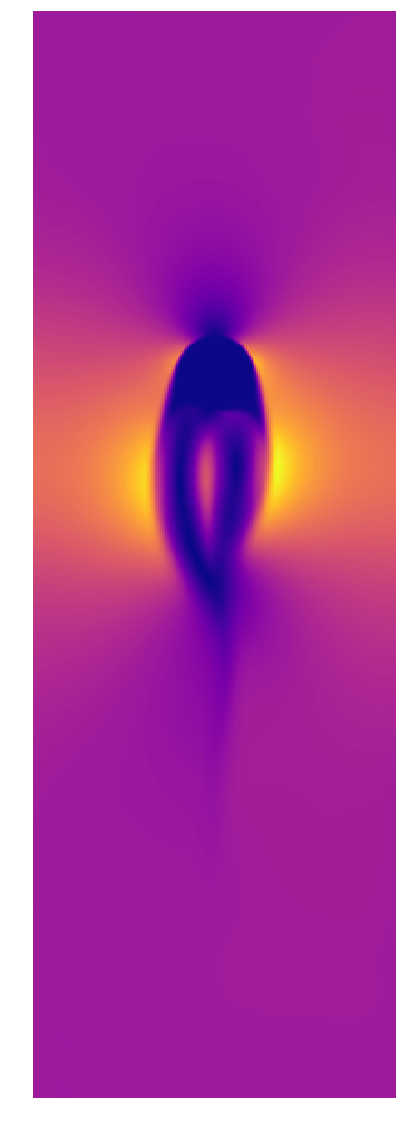

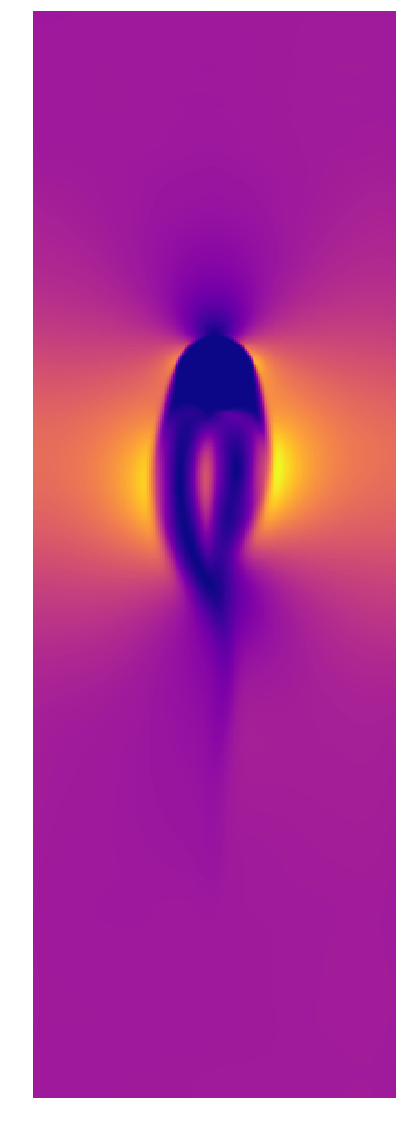

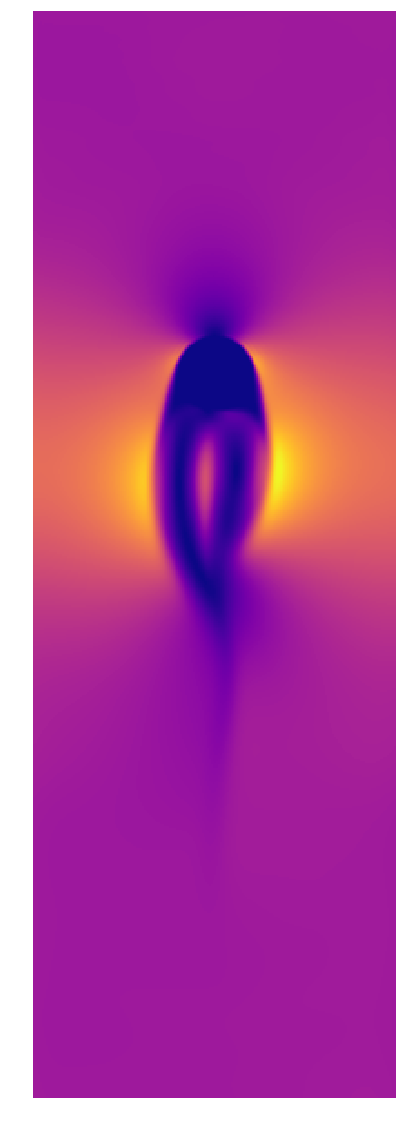

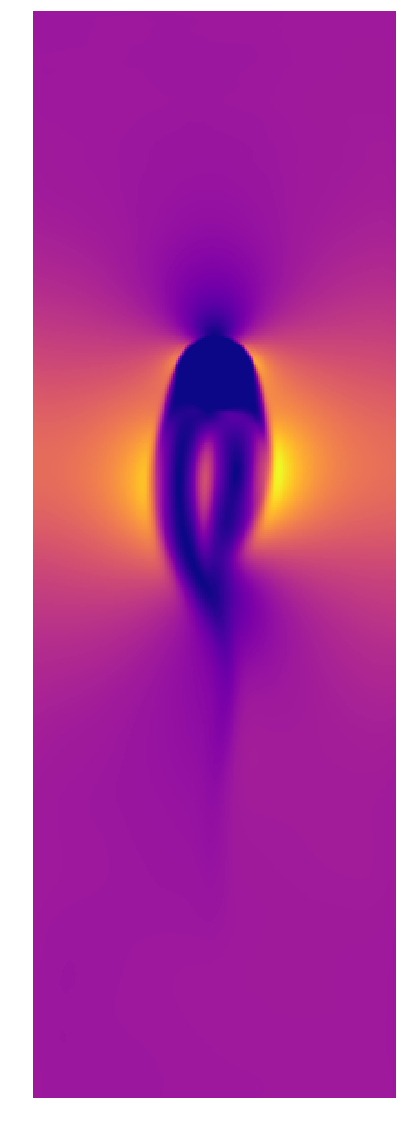

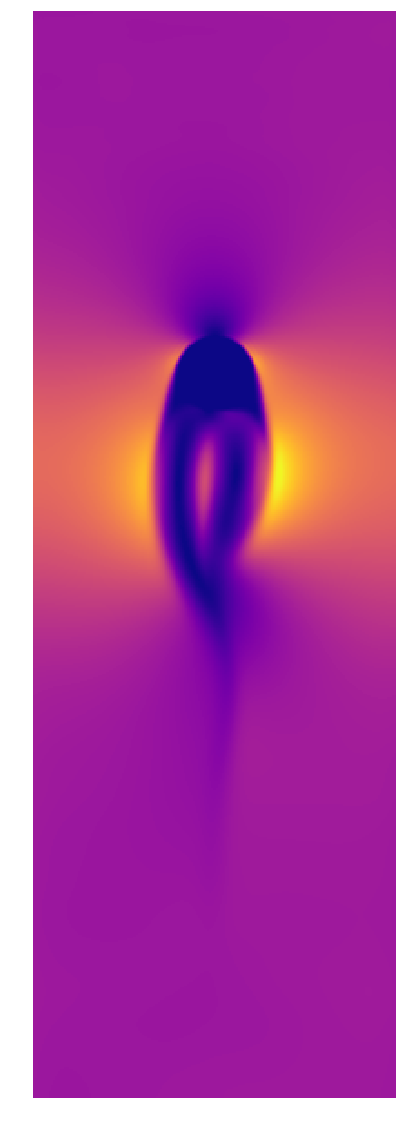

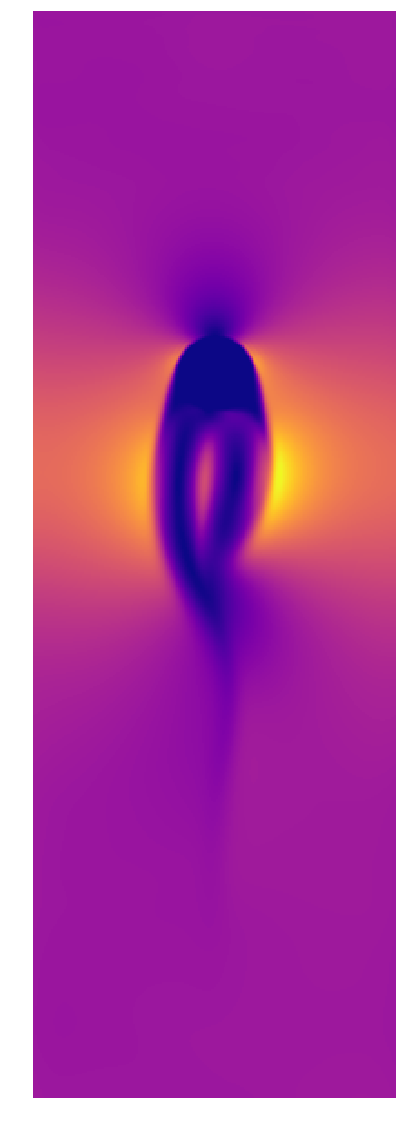

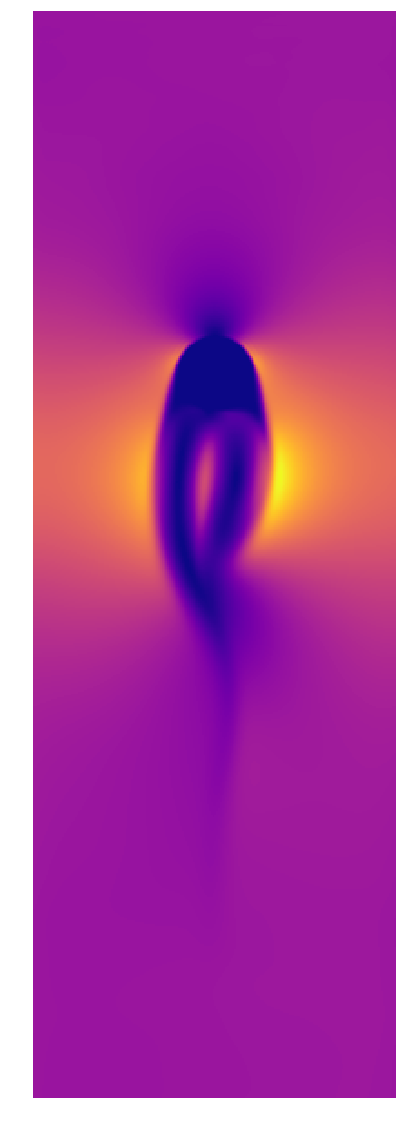

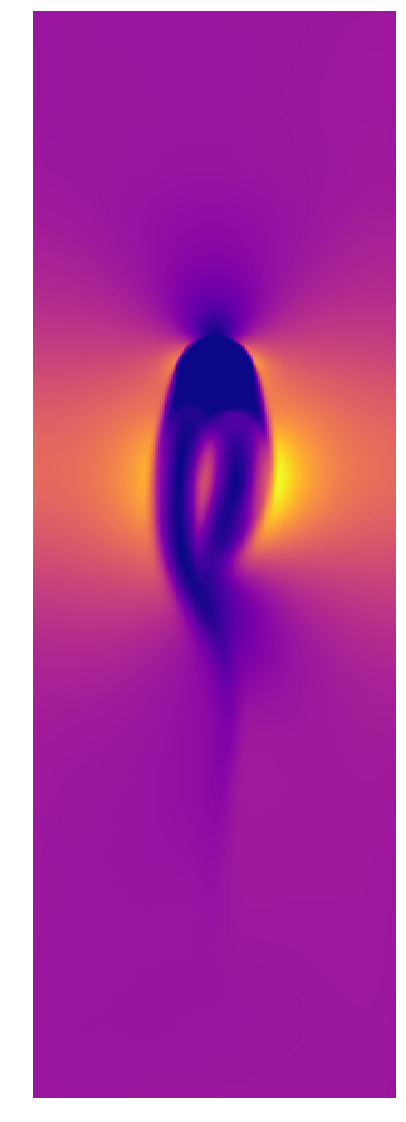

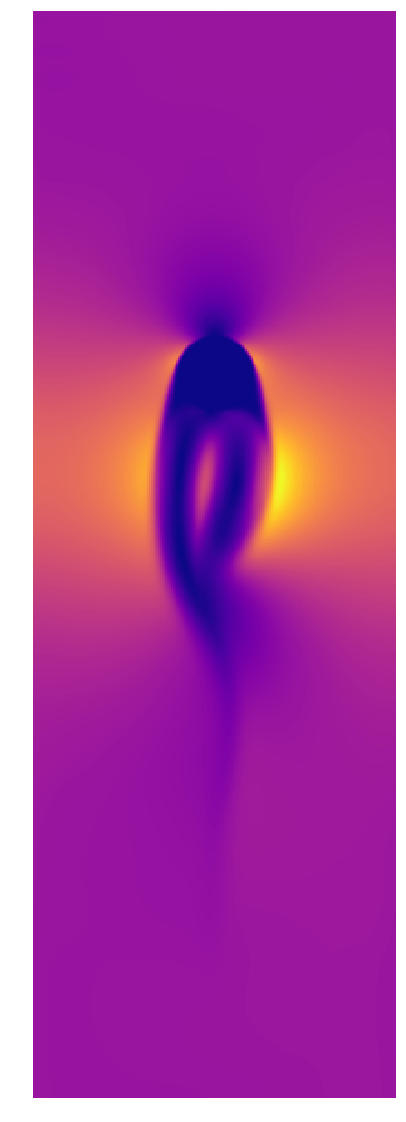

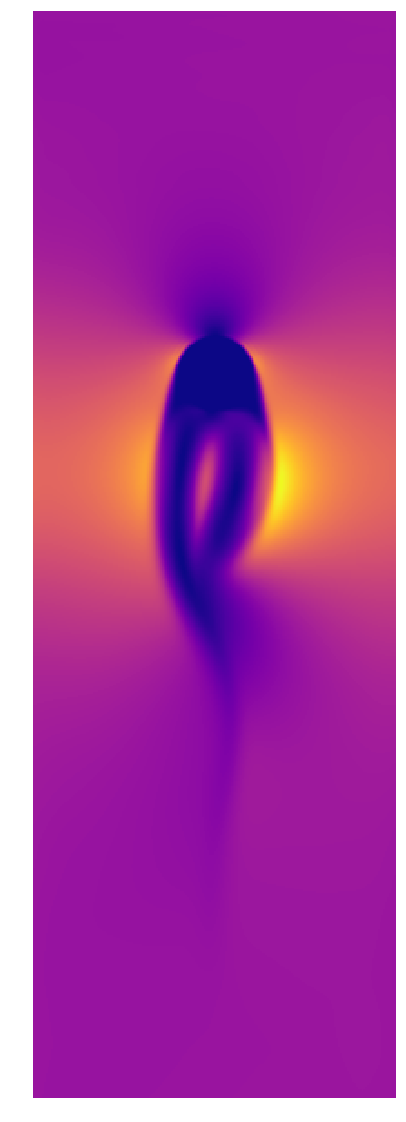

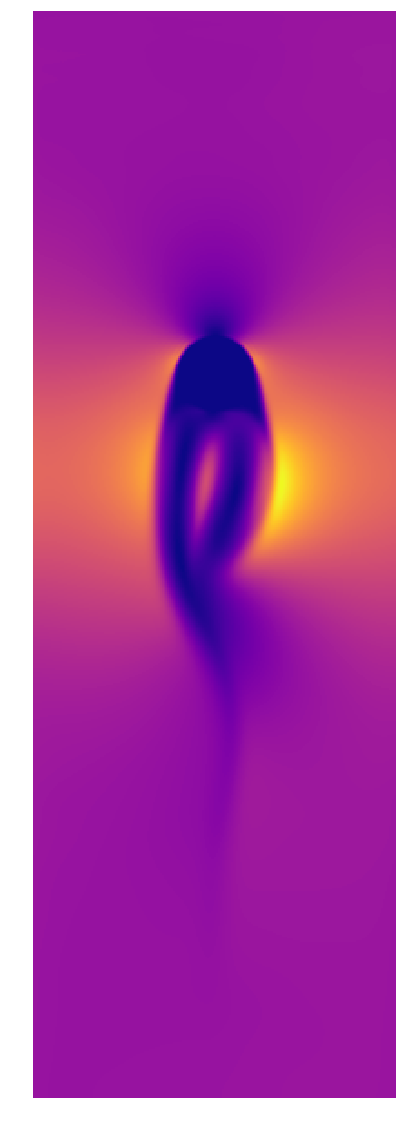

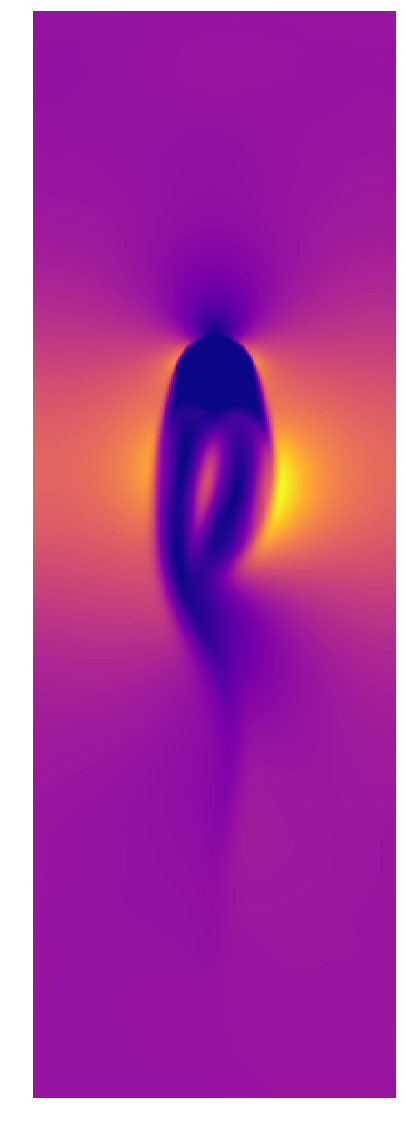

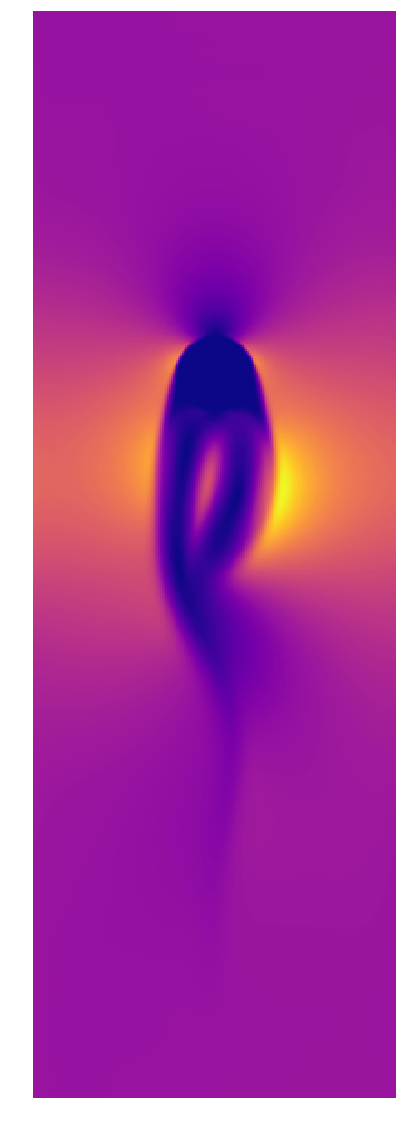

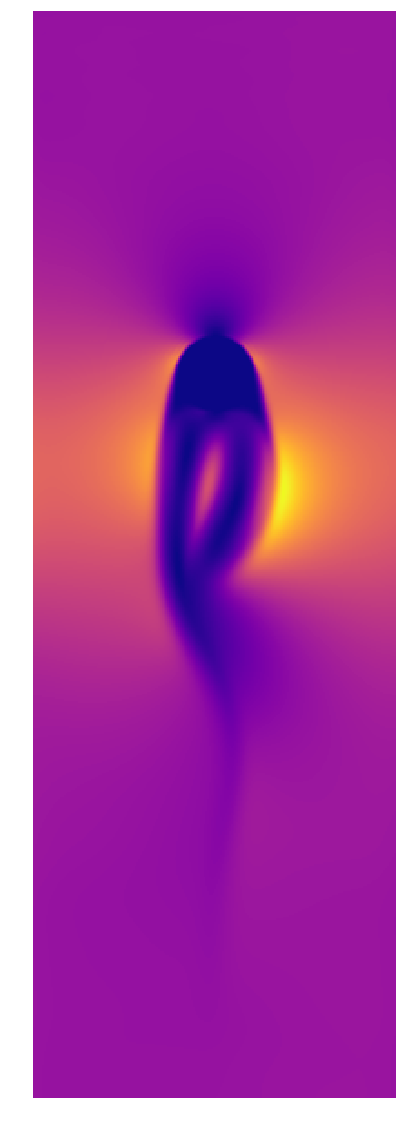

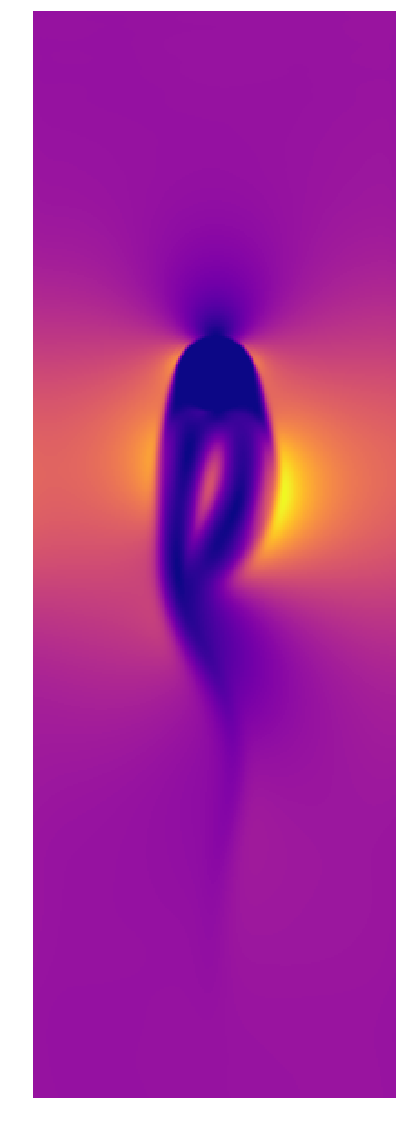

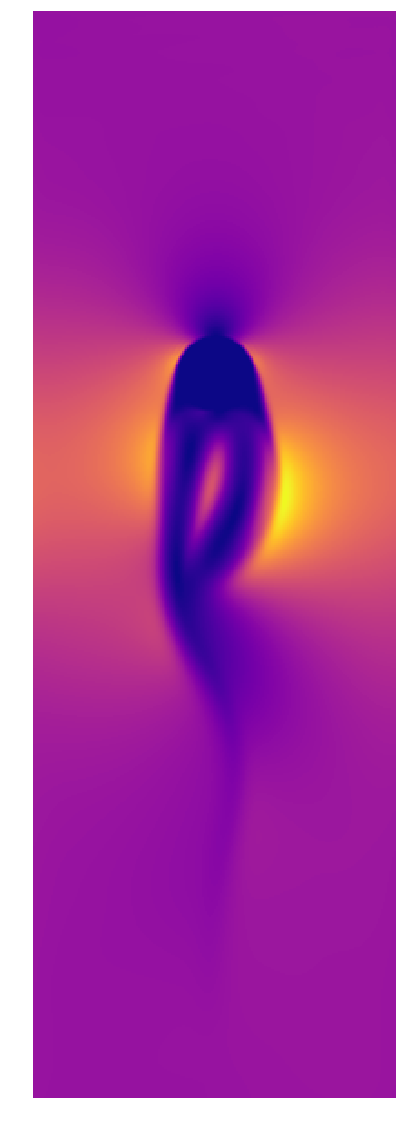

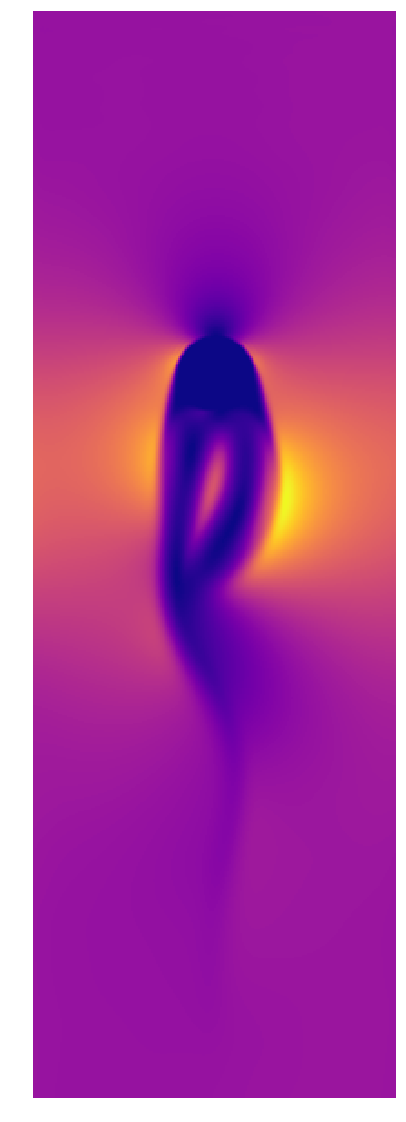

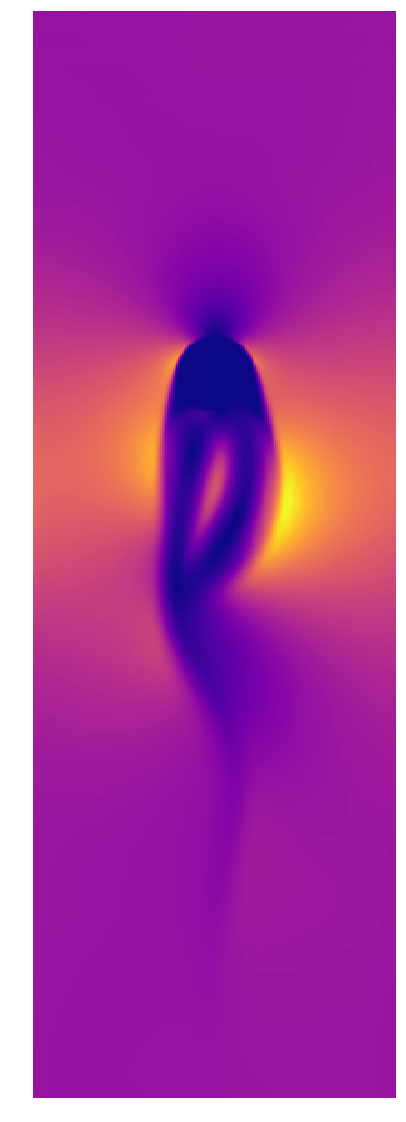

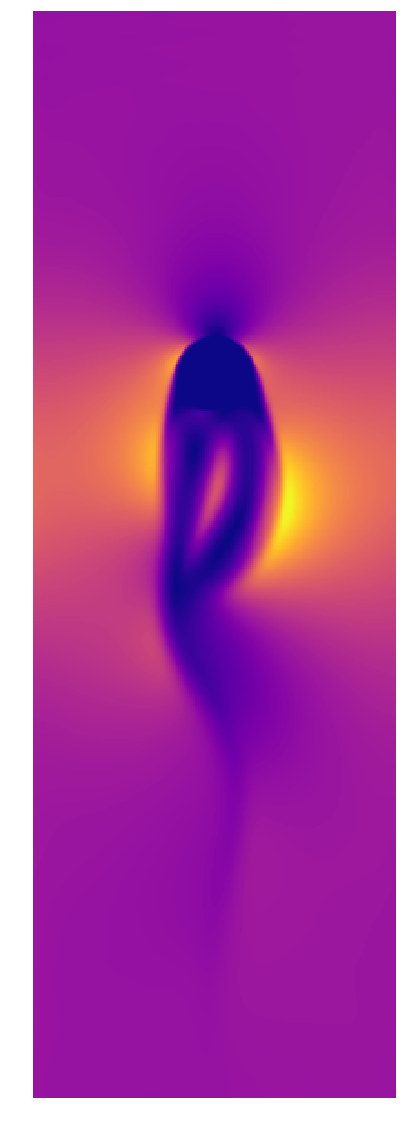

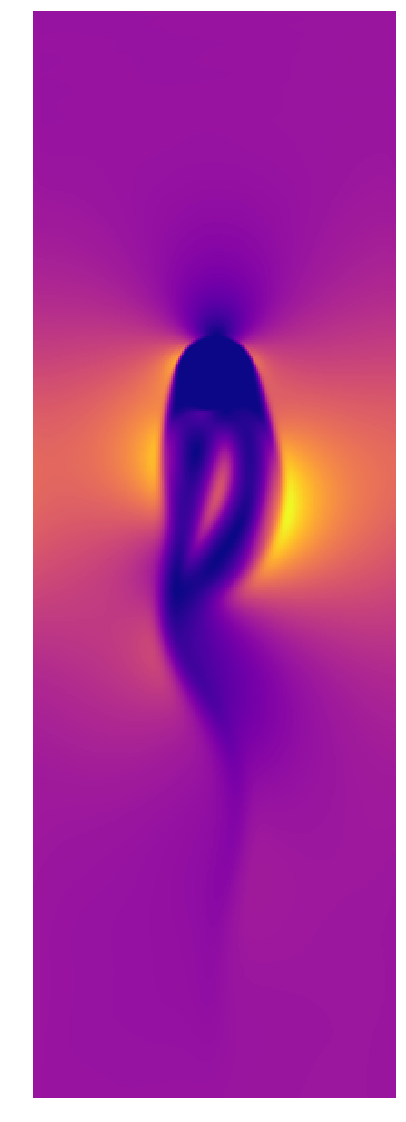

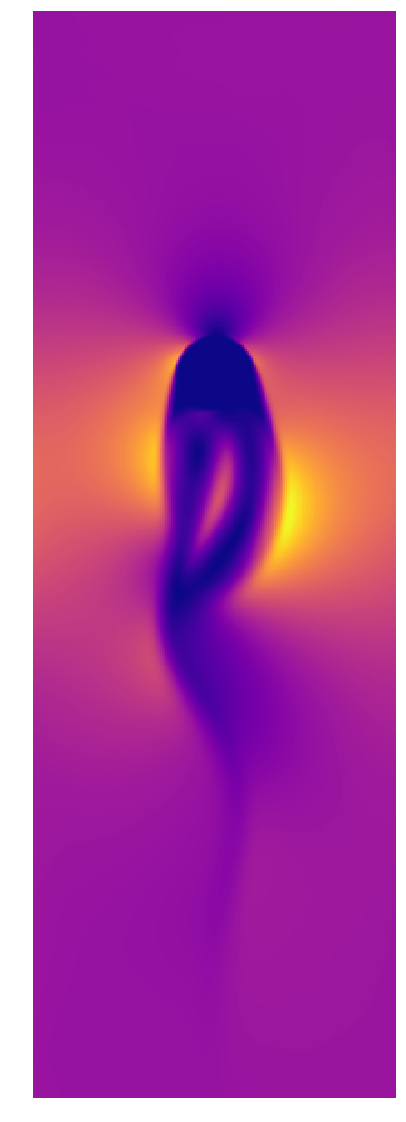

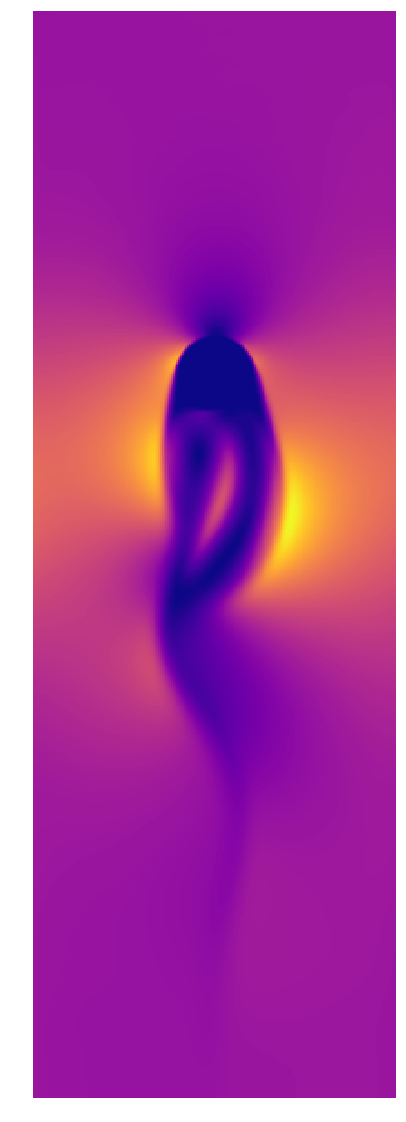

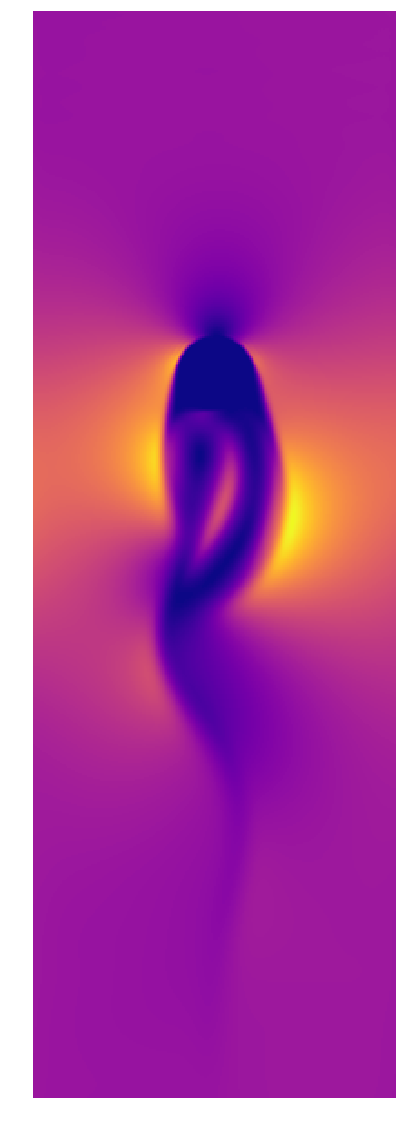

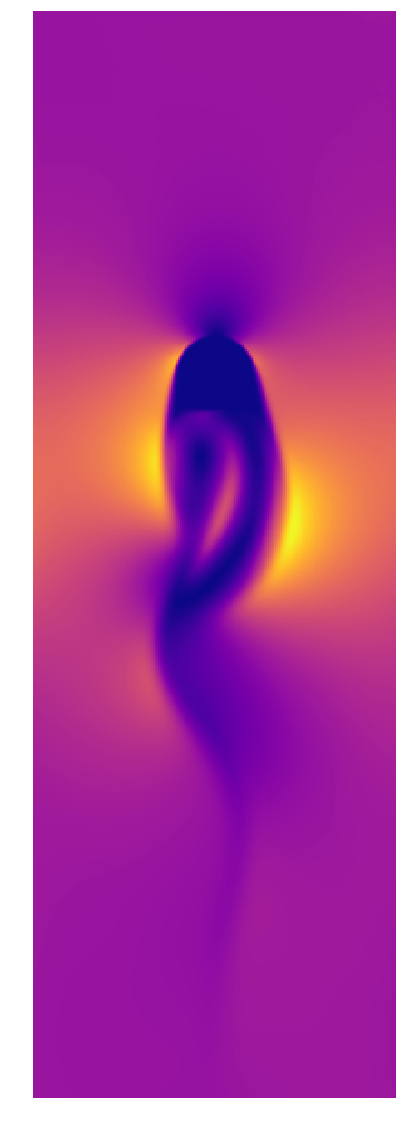

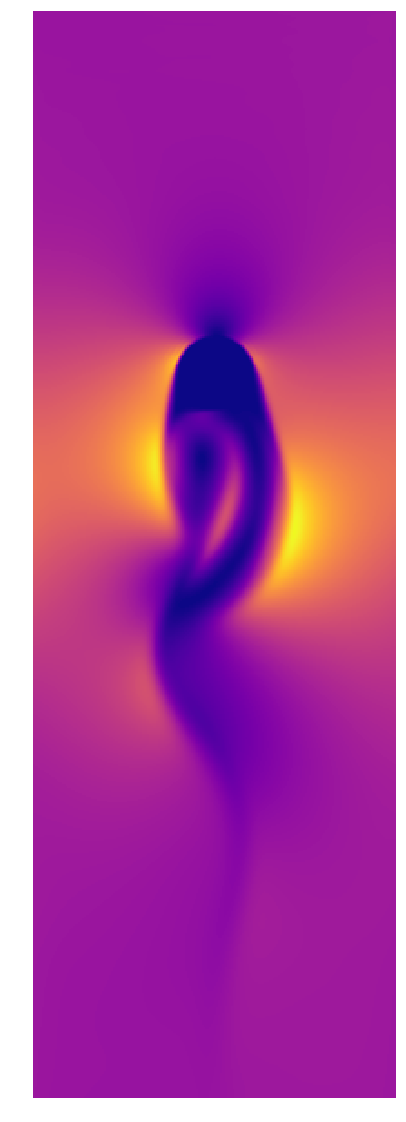

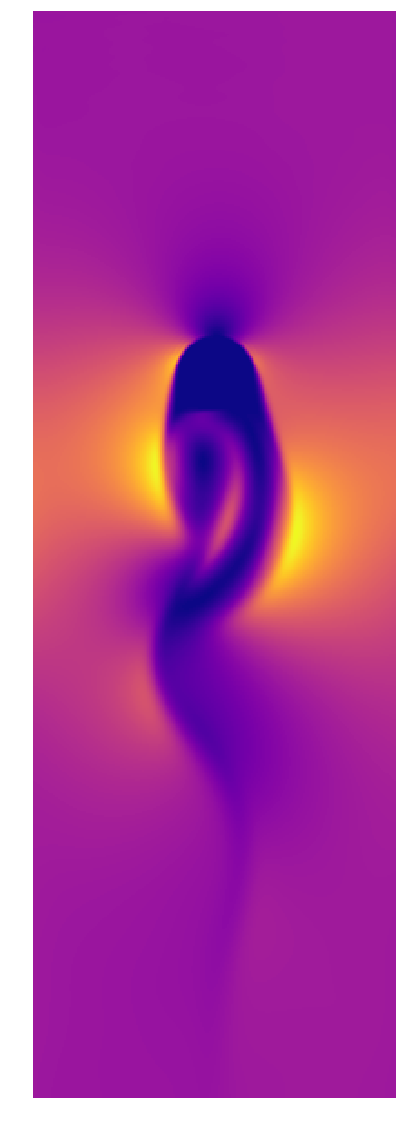

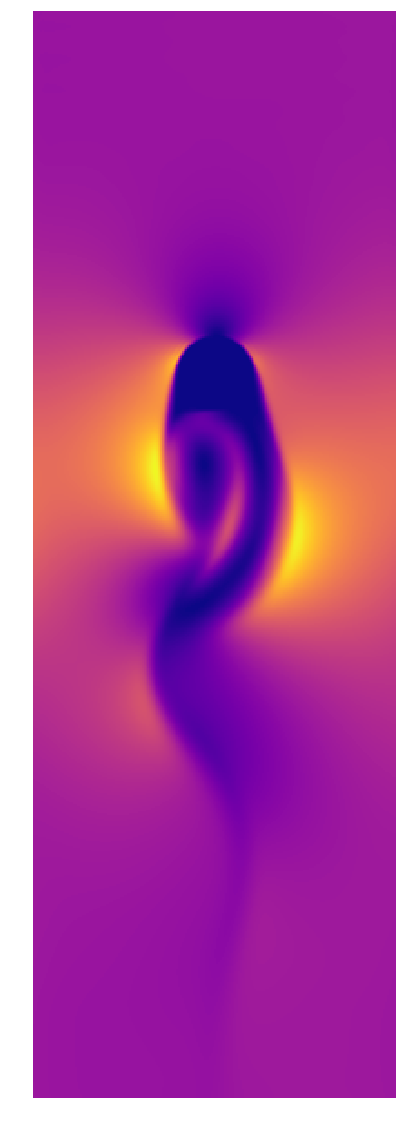

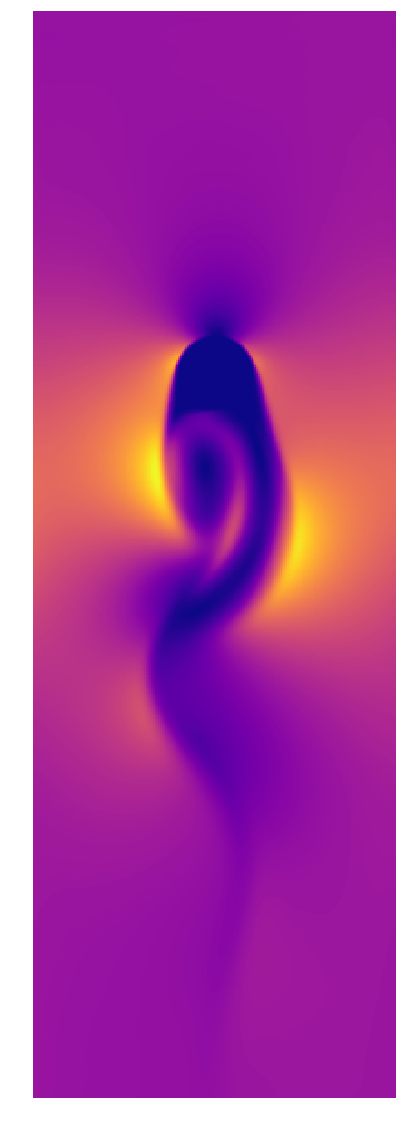

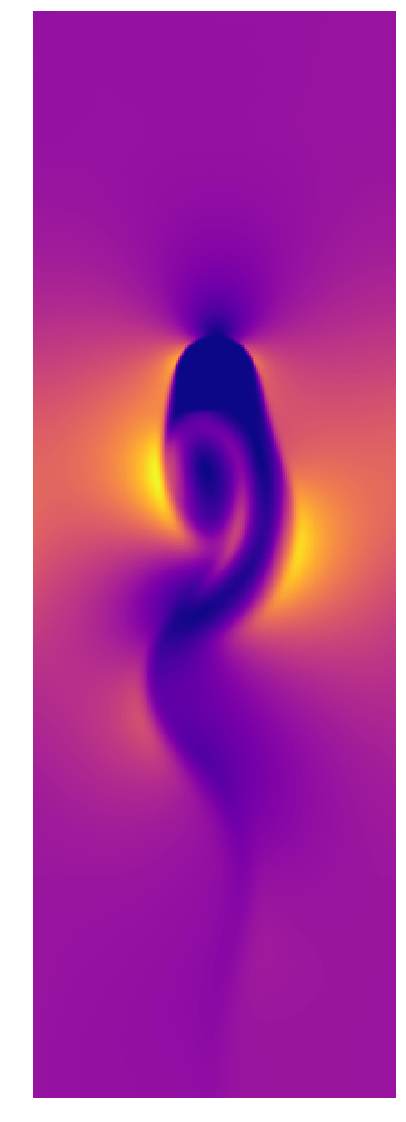

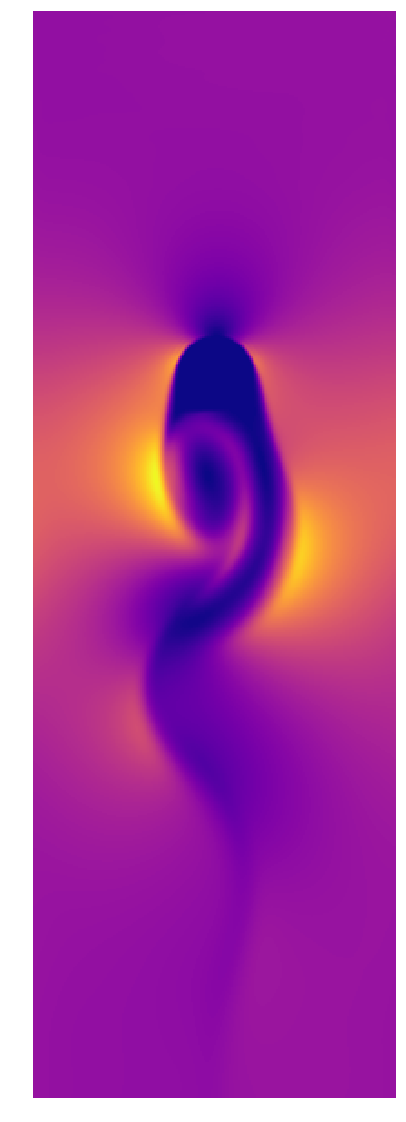

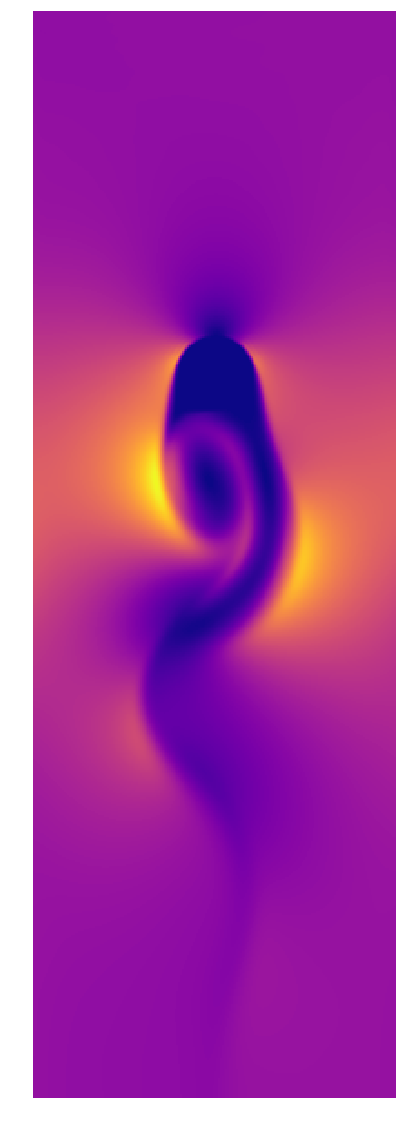

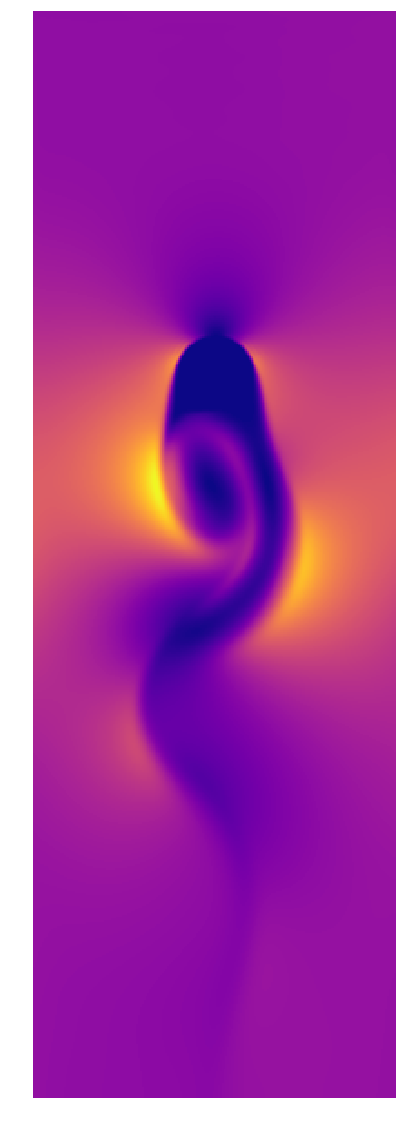

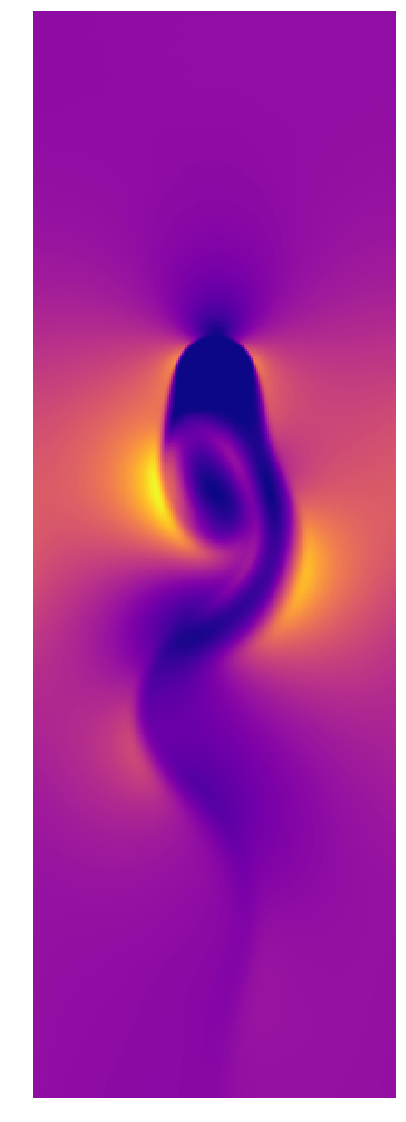

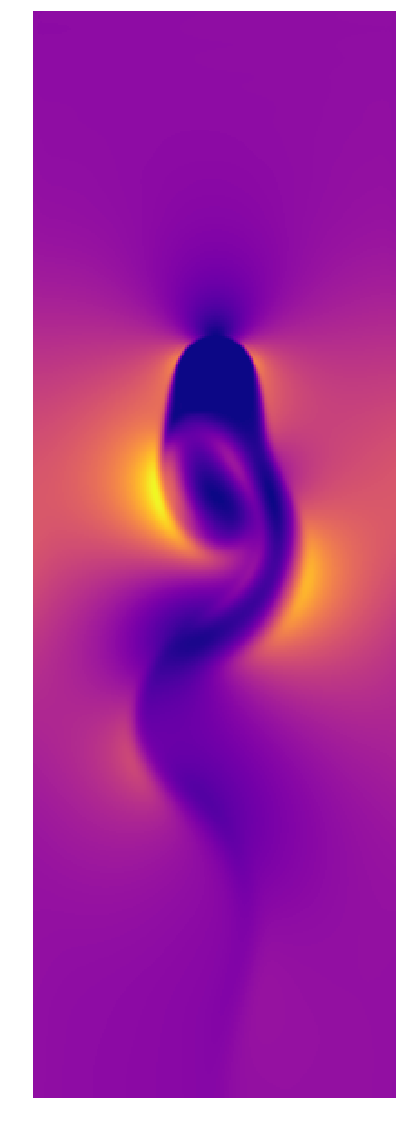

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
Nx=600
Ny=200
R=20
Re=220
uin=0.05
viscosity=uin*R/Re
epsilon=0.1
tau=3*viscosity+ 1/2

e=np.array([[0,0],[1,0],[0,1],[-1,0],[0,-1],[1,1],[-1,1],[-1,-1],[1,-1]])
f=np.zeros((9,Nx,Ny),dtype=float)
velocity=np.zeros((2,Nx,Ny),dtype=float)
density=np.zeros((Nx,Ny),dtype=float)
cx=200
cy=100
cylinder= np.fromfunction(lambda x,y: (x-cx)**2+(y-cy)**2<R**2, (Nx,Ny)) #give one if there is an obstacle there and 0 otherwise
weights=np.array([4/9,1/9,1/9,1/9,1/9,1/36,1/36,1/36,1/36],dtype=float)

uinitial=np.zeros((2,Nx,Ny),dtype=float)
for i in range(Ny):
    uinitial[0,:,i]=uin*(1+epsilon* np.sin(i/(2*np.pi*(Ny-1))))
    


def streaming(fcol):
    f=np.zeros((9,Nx,Ny),dtype=float)
    for i in range(9):
        f[i,:,:]=np.roll(
                        np.roll(fcol[i,:,:],e[i,0],axis=0),
                        e[i,1],axis=1)
    return f

def fequilibrium(density,velocity):
    const1=3
    const2=9/2
    const3=3/2
    veqi=np.zeros((Nx,Ny),dtype=float)
    veqisquare=np.zeros((Nx,Ny),dtype=float)
    velsquare=np.zeros((Nx,Ny),dtype=float)
    feq=np.zeros((9,Nx,Ny),dtype=float)
    allones=np.ones(Nx*Ny,dtype=float).reshape(Nx,Ny)

    
    for i in range(9):
        weight=weights[i]
        veqi=e[i,0]*velocity[0,:,:]+e[i,1]*velocity[1,:,:]
        veqisquare=np.multiply(veqi,veqi)
        velsquare=np.multiply(velocity[0,:,:],velocity[0,:,:])+np.multiply(velocity[1,:,:],velocity[1,:,:])
        feq[i,:,:]=weight*np.multiply(density,allones+const1*veqi + const2*veqisquare-const3*velsquare)
        
        
    return feq

def collision(f,feq):
    fcol=np.zeros((9,Nx,Ny),dtype=float)
    fcol=f- (f-feq)/tau
    return fcol

def leftboundary(f_old,rho_old,velocity): #we need to update the density at both ends (left,right) as well as some directional densities
    u0x=np.zeros(Ny,dtype=float)
    rhoboundary=np.zeros(Ny,dtype=float)

    u0x=uinitial[0,0,:]
    
    rhoboundary=2*(f_old[3,0,:]+f_old[6,0,:]+f_old[7,0,:])+f_old[0,0,:]+f_old[2,0,:]+f_old[4,0,:]
    rhoboundary=np.multiply(np.reciprocal(1-u0x),rhoboundary)
    
    
    rho=np.copy(rho_old)
    rho[0,:]=rhoboundary
    velocity[0,0,:]=u0x
    velocity[1,0,:]=0  
    
    feqsubstitute=fequilibrium(rho,uinitial)
    f=np.copy(f_old)
    f[1,0,:]=feqsubstitute[1,0,:]
    f[5,0,:]=feqsubstitute[5,0,:]
    f[8,0,:]=feqsubstitute[8,0,:]
    
    return f,rho,velocity

def rightboundary(f_old): #we need to update the density at both ends (left,right) as well as some directional densities
    f=np.copy(f_old)
  
    f[3,Nx-1,:]=f_old[3,Nx-2,:]
    f[6,Nx-1,:]=f_old[6,Nx-2,:]
    f[7,Nx-1,:]=f_old[7,Nx-2,:]

    return f

def bounce_back(fin,obstacle):
    reverse= np.array([e.tolist().index((-e[i]).tolist()) for i in range(9)])
    fcol=np.copy(fin)
    for i in range(9): 
        fcol[i,obstacle] = fin[reverse[i],obstacle]
    return fcol #after collision

def calculate_density(f):
    density=np.zeros((Nx,Ny),dtype=float)
    for i in range(9):
        density+=f[i,:,:]
    return density

def calculate_velocity(f,density):
    velocity=np.zeros((2,Nx,Ny),dtype=float)
    for i in range(9):
        for j in range(2):
            velocity[j,:,:]+=np.reciprocal(density)*f[i,:,:]*e[i,j]
    return velocity

def plot(velocity,obstacle):
    plt.close()
    plt.clf()
    velocitysquared=np.multiply(velocity[0,:,:],velocity[0,:,:])+np.multiply(velocity[1,:,:],velocity[1,:,:])
    fig=plt.figure(figsize=(20,20))
    plt.axis("off")
    velocitysquared[np.where(obstacle)]=0
    #vmax=0.0025
    #vmin=0
    #norm = cm.colors.Normalize(vmax=vmax, vmin=vmin)
    plt.imshow(velocitysquared,cmap=cm.plasma, interpolation='nearest')#,norm=norm)    
    return 1

totaltime=200000

density=np.ones(Nx*Ny).reshape(Nx,Ny)
velocity=uinitial
f=fequilibrium(density,velocity)
obstacle=cylinder

for t in range(totaltime):
    f=rightboundary(f)
  
    density=calculate_density(f)
    velocity=calculate_velocity(f,density)

    f,density,velocity=leftboundary(f,density,velocity)
    
    feq=fequilibrium(density,velocity)
    
    f[1,0,:]=feq[1,0,:]
    f[5,0,:]=feq[5,0,:]
    f[8,0,:]=feq[8,0,:]
    
    f=collision(f,feq)
    f=bounce_back(f,obstacle)
    f=streaming(f)
    if((t+1)%100==0):
        plot(velocity,cylinder)
        plt.savefig("ev"+str(int((t+1)/100))+".png")
        plt.show()
plot(velocity,cylinder)

        
    
    